# ML1 Project: Predicting Political Ideology from Economic Indicators

## Table of Contents
* [1 Introduction](#1)
* [2 Data Cleaning & Preparation](#2)
* [3 Exploratory Data Analysis (EDA)](#3)
* [4 Hypothesis](#4)
* [5 Modeling](#5)
    * [5.1 Linear Model (LM)](#5.1)
    * [5.2 Generalized Linear Model (GLM) - Poisson/Binomial](#5.2)
    * [5.3 Generalized Additive Model (GAM)](#5.3)
    * [5.4 Neural Network (NN)](#5.4)
    * [5.5 Support Vector Machine (SVM)](#5.5)
* [6 Results](#6)
* [7 Conclusions & Recommendations](#7)
* [8 AI Usage Reflection](#8)
* [9 Team Contributions](#9)

---


* global leader ideologies dataset description: https://github.com/bastianherre/global-leader-ideologies/blob/main/README.md

* GEM :https://www.kaggle.com/datasets/prasad22/global-economy-indicators

* military spending: https://data.worldbank.org/indicator/MS.MIL.XPND.GD.ZS

* rural/urban population counts: https://www.kaggle.com/datasets/hassanzahid233/world-population-and-unemployment-dataset

## <a id='1'></a>1. Introduction

### Objective

The objective of this analysis is to examine whether a country’s dominant political ideology – categorized as left, center, or right – can be predicted from its economic indicators. We also explore how economic metrics (e.g. growth, trade, military spending) correlate with shifts in political ideology or election outcomes, and whether countries cluster into profiles with similar economic-political characteristics. Rickardsson (2021) suggests that there is a divide between urban and rural populations for voting characteristics. Possibly because of lower access to public services in rural areas, they respond to the deterioration of their location by casting a vote on the far-right. Economic voting phenomena suggests that, voters hold the major incumbent party accountable for recent economic performance while voting. In addition, recent research shows that higher levels of GDP in a country result in greater far-right preference (Lucassen &  Lubbers ,2011). In authoritarian regimes, military spending tends to be higher than in democratic regimes while right-wing governments spend more on arms purchases and left-wing governments spend more on military personnel (Carter,2016). In the light of these findings, we wanted to explore the relationship between leader ideologies, economic indicators, military spending and urban population counts using predictive modeling.

The project involves assembling data from multiple sources, conducting thorough exploratory data analysis (EDA), building predictive models, and interpreting key drivers, all compiled into a client-ready report. Below, we present the process and findings in a structured manner.

### Research Questions
1. Are economic indicators related to selected leader ideologies?
2. Can we predict military spending from leader ideologies and other economic indicators?
3. Is there a relationship between urban population counts with leader ideologies and other economic indicators?

### Definitions 

| 🔴 Left | 🟡 Centrist | 🔵 Right |
| --- | --- | --- |
| Left politics: Fair share for all, strong public services, government intervention to reduce inequality.<br>**Examples:** Venezuela, Bolivia, Cuba | Centrist politics: Compromise, pragmatic, balances both state and market.<br>**Examples:** Germany, Canada, Chile | Right politics: Free markets, less government, individual responsibility.<br>**Examples:** USA, UK, Australia |

In [1]:
# Imports (deduplicated and grouped)
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    r2_score, mean_squared_error,
    roc_auc_score,
    roc_curve,
    auc,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import warnings
warnings.filterwarnings('ignore')
from pygam import LinearGAM, s, f, te
import math
from functools import reduce
from operator import add
import numpy as np
import scipy as sp
import scipy.sparse

def to_array(self):
    return self.toarray()

scipy.sparse.spmatrix.A = property(to_array)

import pygam
from scipy import sparse

## <a id='2'></a>2. Data Cleaning & Preparation
Data Sources: We worked with three datasets provided in ML1-HSLU-main.zip:
- **Global Economy Indicators** – Annual economic data for countries (e.g. GDP, GNI, sector outputs, trade). from 
- **Global Leader Ideologies** – Yearly classification of each country’s head-of-government ideology (left/center/right) from 1945–2020.
- **Military Spending** – Country-level military expenditure as % of GDP (World Bank indicator). from
- **Rural/Urban Population** - Unemployment (%) and population (count)  data from


| Step | What we did |
| --- | --- |
| **1. Extraction & First Look** | We unzipped every file and read them into data frames.<br>The economy file holds 26 indicators for 200 + countries (≈ 1970 – 2021).<br>The ideology file tags leaders in ~180 countries (1945 – 2020).<br>The military file tracks defence spending for ~260 entities (1960 – 2023).<br>We saw each file used different country codes, so a common key was needed. |
| **2. Trimming & Encoding** | We stripped extra spaces (e.g., “ Afghanistan ” → “Afghanistan”) and fixed text encoding so names line up. |
| **3. Country Name Match-up** | We built a mapping to bring names in line.<br>Examples:<br>• “United States” → “United States of America”<br>• “Bolivia (Plurinational State of)” → “Bolivia”<br>• Merged old entries like “Yemen Arab Republic (Former)” into today’s names. |
| **4. Handling Missing Values** | Ideology rows labelled “no information” were dropped, so the model sees only clear left / center / right tags. |
| **5. Wide → Long Reshape** | The military data was pivoted from wide to long, giving one row per country-year. |
| **6. Final Merge & Clean-up** | Using aligned country names and year, we joined all three sets.<br>The final frame covers 1990 – 2020, ~2 897 rows, 266 countries, 25 columns that include:<br>• Economic stats (GDP, GNI, sectors, trade)<br>• Military spend (% GDP)<br>• Leader ideology, democracy flag, gov-leader match, region<br>• Urban & rural populations.<br>Rows with key gaps were dropped so models get complete cases. |

We confirmed that key variables like GDP and GNI are in units (economy data indicated GNI in USD), rows with incomplete features and missing data were dropped for modeling to ensure algorithms receive complete cases.



## <a id='3'></a>3. Exploratory Data Analysis
With a clean, merged dataset, we performed EDA to understand the distributions of variables, relationships between economic indicators and ideology, and potential multicollinearity or clustering patterns.

**Summary Statistics:** We first examined summary stats for the key indicators. There is wide variability in country economic profiles – e.g. population ranges from microstates under 100k to countries over 1 billion; GDP ranges several orders of magnitude. Economic metrics are highly skewed (a few very large economies drive the upper ranges), which justifies our use of log transforms for analysis. The **ideology distribution** in the data is roughly: 49% leftist, 41% rightist, and 10% centrist (counting each country-year as one observation). This indicates centrist governments are comparatively rare in the dataset, a point to keep in mind for modeling (class imbalance). We also noted potential regional patterns: for example, many Western European and North American entries are coded as center or right, whereas a number of Latin American and African country-years are coded as left (often in the context of socialist or populist leaders in certain periods). These are general trends – we will explore if the data supports them.


In [110]:
data = pd.read_csv("processed_data/new_data_with_count.csv")
data.dropna()
data.rename(columns={'Gross.National.Income.GNI..in.USD': 'gross_national_income_GNI', 'Military.expenditure....of.GDP.': 'military_expenditure','Gross.Domestic.Product..GDP.': 'GDP'}, inplace=True)
valid_ideologies = ["leftist", "rightist", "centrist"]

data= data[data["leader_ideology"].isin(valid_ideologies)]
data= data[data["hog_ideology"].isin(valid_ideologies)]
# Ensure democracy is binary (convert 'yes'/'no' to 1/0 if needed)
data.columns = data.columns.str.replace('.', '_', regex=False)

data.dropna();

In [3]:

print(data.describe().iloc[:, :5])

        Unnamed: 0         Year  IMF_based_exchange_rate    Population  \
count  2910.000000  2910.000000             2.910000e+03  2.910000e+03   
mean   1476.279381  2005.403780             3.590835e+02  4.874920e+07   
std     856.492919     8.782866             1.277384e+03  1.615665e+08   
min       1.000000  1990.000000             2.990000e-08  3.653920e+05   
25%     731.250000  1998.000000             1.000000e+00  4.519950e+06   
50%    1474.500000  2005.500000             6.459693e+00  1.046894e+07   
75%    2219.750000  2013.000000             1.014537e+02  2.953516e+07   
max    2954.000000  2020.000000             1.458220e+04  1.424930e+09   

       Per_capita_GNI  
count     2910.000000  
mean     11779.468385  
std      16642.161340  
min         93.000000  
25%       1129.500000  
50%       3831.000000  
75%      15868.000000  
max     103989.000000  


We see that min year is 1990 and max is 2020 so this confirms our filter. Mean military expenditure is aroung 2 percent of GDP, In the dataset urban and rural population counts seem to be balanced. Mean GDP is 4753213e+11. Compared to other sectors, wholesale seems to be the one with the highest USD output. SD is high in construction outputs.

Visualizing correlations helps us see how variables relate, but before we need to define target and features because we have many variables right now.

In [5]:
features = ['IMF_based_exchange_rate', 'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'Changes_in_inventories', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']

X = data[features]
y = data['leader_ideology']

Except changes in inventories, all the variables are right skewed. So we do log transformations to normalize the distribution and check distribution plots:

In [111]:

selected_cols = ['IMF_based_exchange_rate','Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI', 'GDP', 'military_expenditure', 'Urban_population', 'Rural_population']

# Apply log transform
df_log = data.copy()

df_log[selected_cols] = np.log1p(df_log[selected_cols])  # or np.log1p() if values may be zero


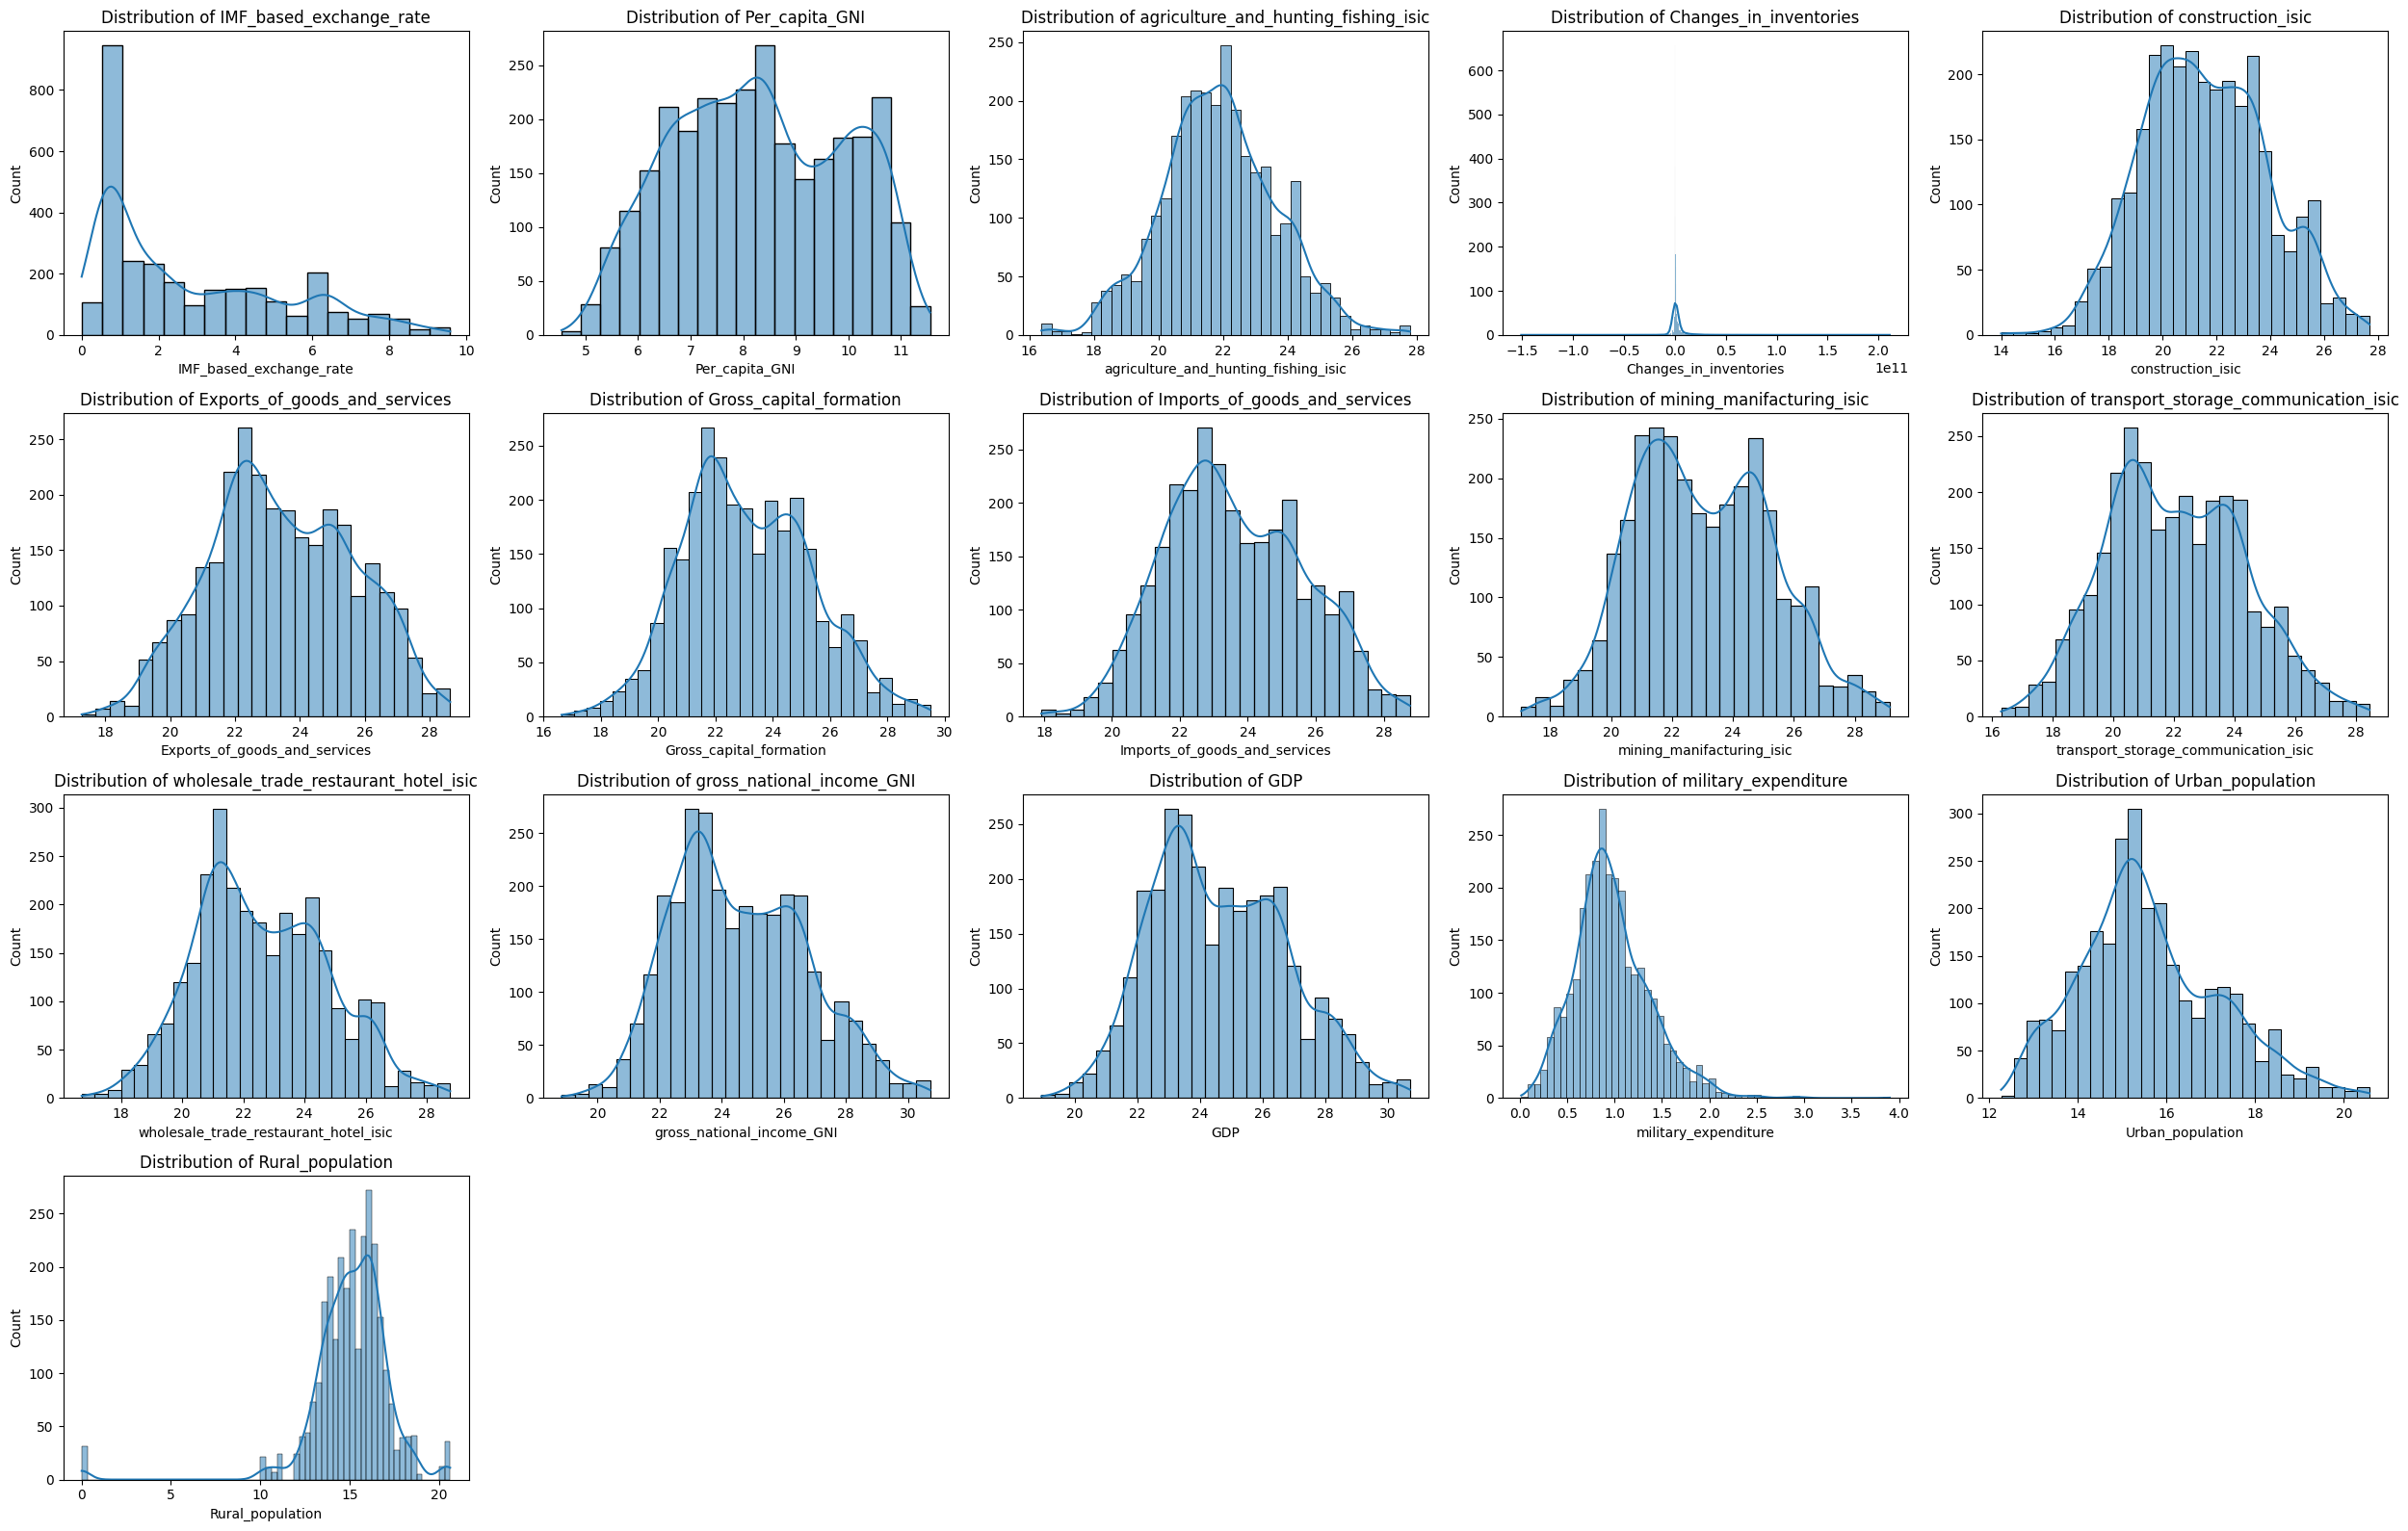

In [8]:
# 🚩
cols   = 5
n      = len(features)
rows   = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df_log[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

We see that after log transformation most of the variables follow a Gaussian distribution.

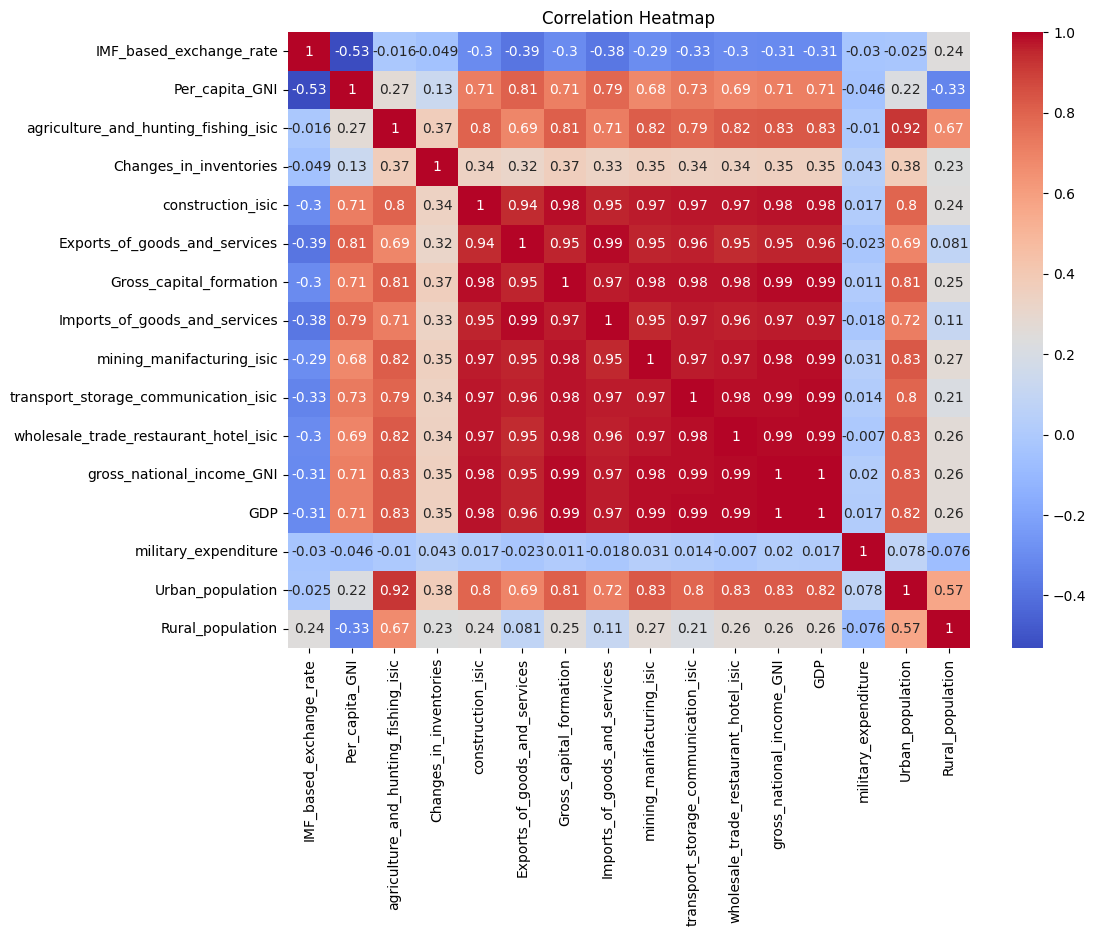

In [9]:
plt.figure(figsize=(11,8))
sns.heatmap(df_log[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Interpretation from the Heatmap
1. Strong Positive Correlations :
* **Exports vs. Imports** : Near-perfect correlation (0.99). Countries with high exports also import heavily, reflecting open economies.
* **Sectoral Shares** : Construction, mining/manufacturing, transport, and wholesale sectors are highly correlated (0.95–0.99), indicating overlapping economic activities.
* **GDP vs. Sectoral Components** : GDP is strongly tied to Gross Capital Formation (0.99) and other sectoral shares (0.96–0.99), as expected.
2. Negative Correlations :
* **Agricultural Share vs. Per Capita GNI** : Strong negative correlation (-0.31), confirming that agrarian economies tend to have lower income levels.
* **IMF Exchange Rate vs. Economic Indicators** : Weak/negative correlations (e.g., -0.53 with Per Capita GNI), suggesting limited influence on growth.
* **Military Spending** :
3. Weakly correlated with most economic metrics (e.g., 0.02 with GDP), we assume that defense spending varies idiosyncratically.

According to our correlation plot we have high correlation among some variables. In the light of these results, we define our target variables that are related to our hypothesis as : 

    'Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic' 'transport_storage_communication_isic','GDP','Urban_population','leader_ideology','democracy','military_expenditure'

## Ideology distribution


Now lets check the relationship between our variables. 

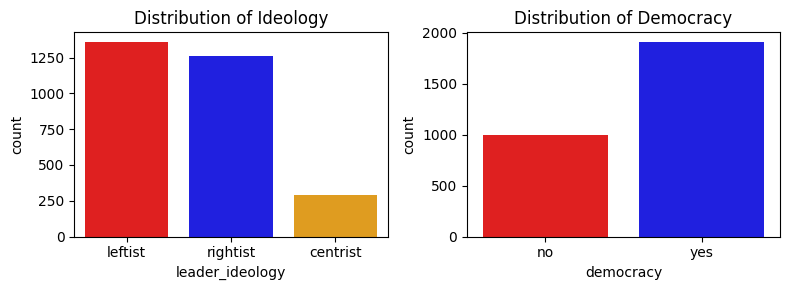

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 4, 3))   # 3 plots × 5 in wide × 4 in tall

# ---  count-plot: leader_ideology ----------------------------------------
sns.countplot(
    data=df_log, x='leader_ideology', hue='leader_ideology', dodge=False, palette=['red', 'blue', 'orange'], legend=False, ax=axes[0]
)
axes[0].set_title('Distribution of Ideology')

# ---  count-plot: democracy ----------------------------------------------
sns.countplot(
    data=df_log,
    x='democracy', hue='democracy', dodge=False, palette=['red', 'blue'], legend=False, ax=axes[1]
)
axes[1].set_title('Distribution of Democracy')

plt.tight_layout()
plt.show()

### Interpretation from the Plots
1. **Distribution of Leader Ideology**
Key Insight :
Leftist ideology dominates the dataset (highest count), followed by rightist , with centrist being the least represented.
Implication : The dataset may reflect a historical or regional bias toward leftist governance, which could influence correlations with economic/military metrics (e.g., Carter’s finding that left-wing governments prioritize military personnel).
2. **Distribution of Democracy**
Key Insight :
Democratic regimes ("yes") outnumber non-democratic regimes ("no") significantly.
Implication : Analysis of political-economic relationships may need to account for the overrepresentation of democracies, potentially masking trends in authoritarian contexts.

We want to understand our target variable leader ideologies better. Below we will plot its relation with all the variables of interest:

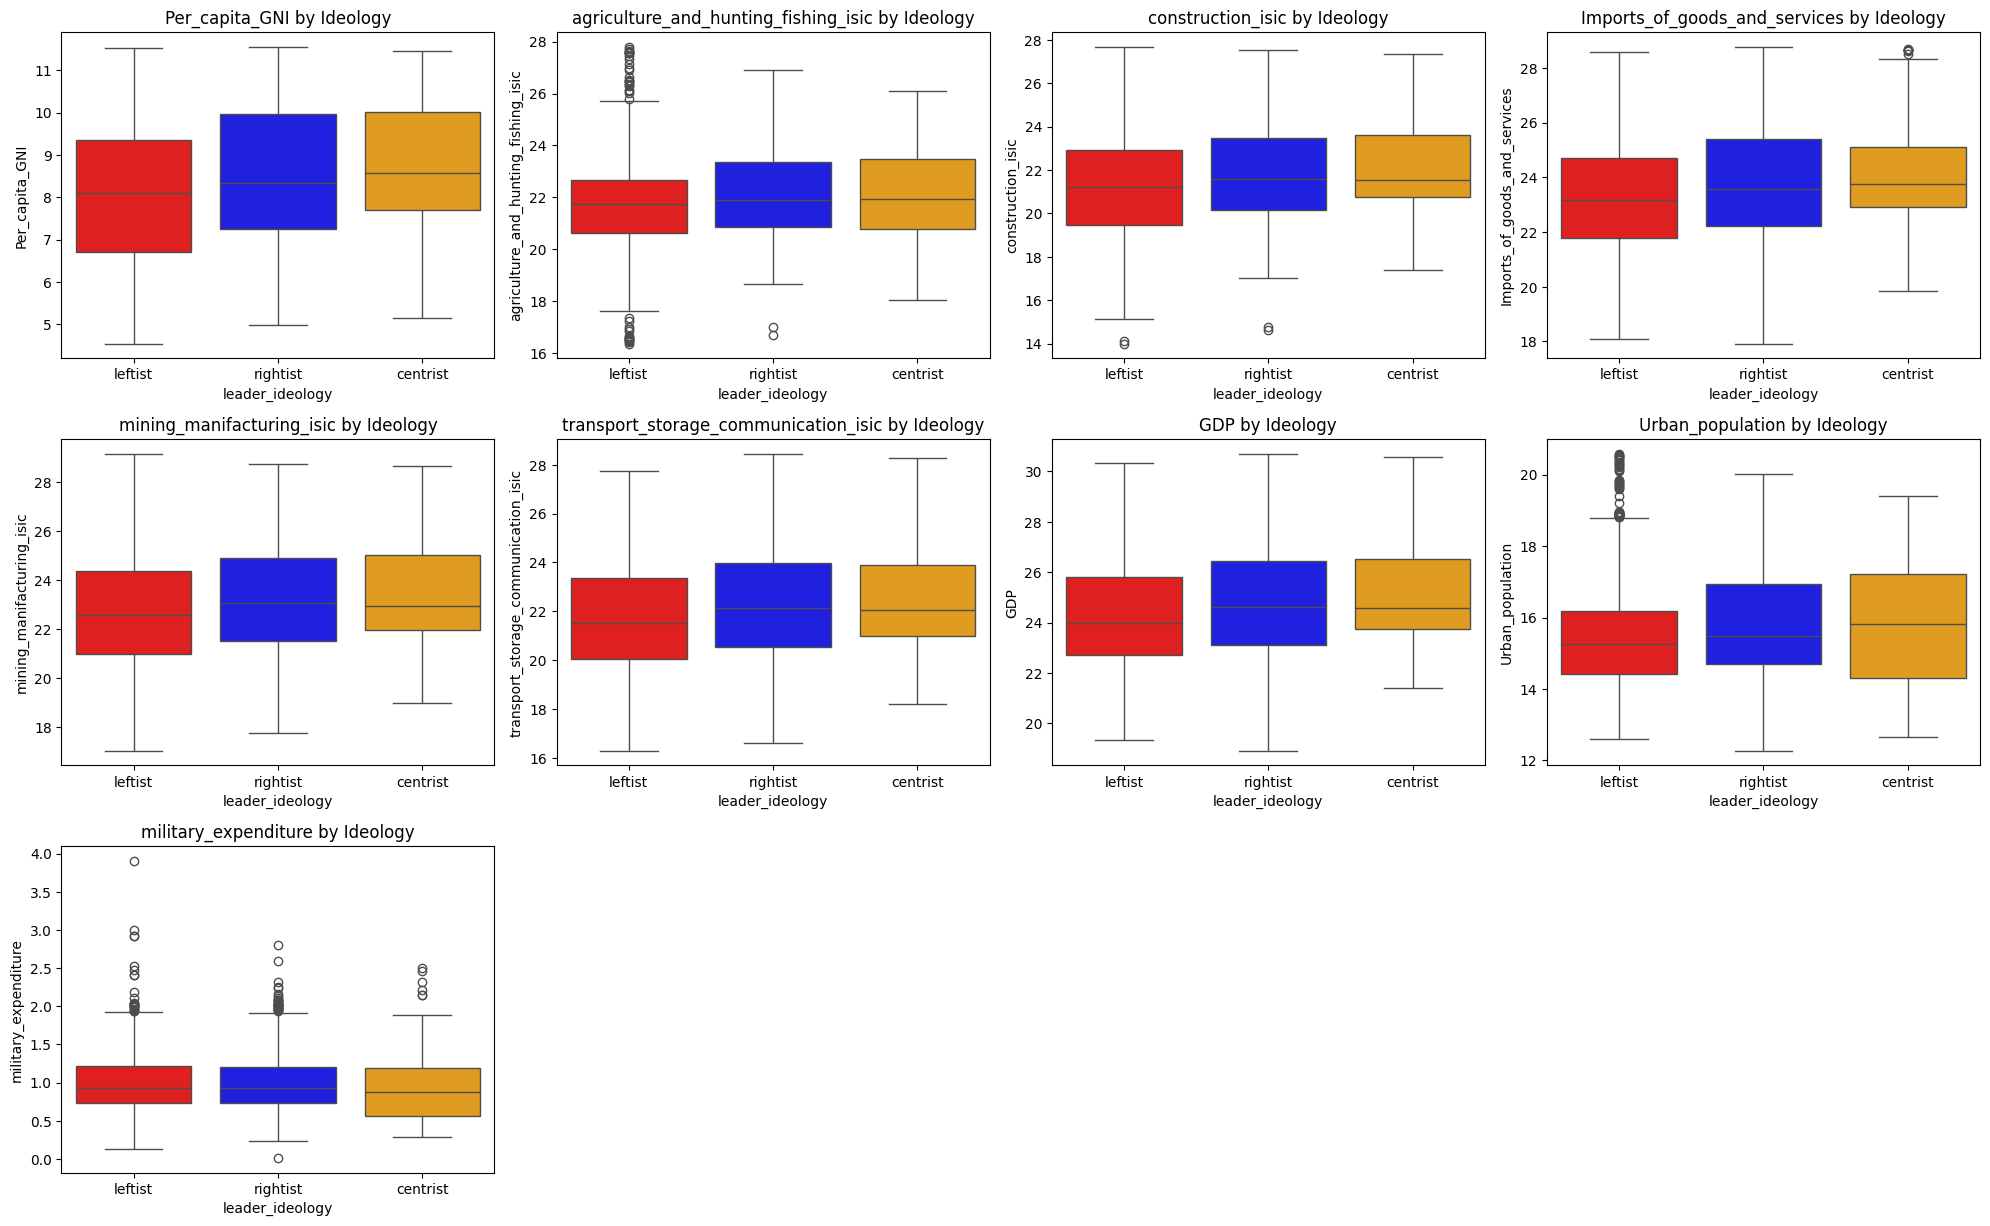

In [11]:
cols   = 4
n      = len(features)
rows   = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)

axes = axes.flatten()

columns_to_plot = [
    'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic',
    'construction_isic',
    'Imports_of_goods_and_services',
    'mining_manifacturing_isic',
    'transport_storage_communication_isic',
    'GDP',
    'Urban_population',
    'military_expenditure'
]

for i, feature in enumerate(columns_to_plot):
    sns.boxplot(data=df_log, x='leader_ideology', y=feature, hue='leader_ideology', dodge=False, palette=['red', 'blue', 'orange'], legend=False, ax=axes[i])
    axes[i].set_title(f'{feature} by Ideology')

for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

### Interpretation from the Plots

1. **Military Expenditure**: Rightist ideologies show higher median military spending as %GDP, which aligns with Carter's findings. This supports the hypothesis that right-wing governments spend more on arms. However, there's overlap, indicating it's not a strict rule.

2. **Per Capita GNI**: Leftist ideologies have lower per capita GNI compared to rightist and centrist. This matches the negative correlation noted earlier between agricultural share and income.

3. **Agriculture Sector**: Higher in leftist and centrist, lower in rightist, suggesting agrarian economies are more left-leaning.

4. **Exports and Imports**: Similar across ideologies, indicating trade openness isn't a distinguishing factor here.

5. **Urban Population**: Centrists have higher urban populations, which might relate to economic development.

Now let's check the relationship of military expenditure and per capita gni grouped by democracy and leader ideologies.

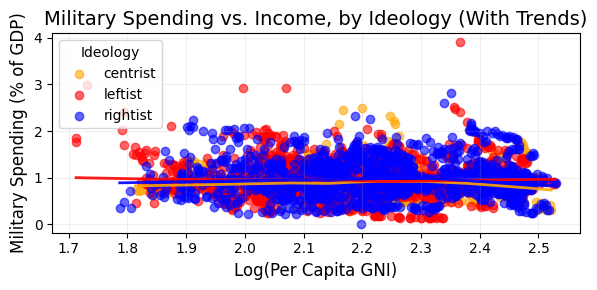

In [12]:
# Ensure required log-transformed column exists
if 'log_GNI' not in df_log.columns:
    df_log['log_GNI'] = np.log1p(df_log['Per_capita_GNI'])  # Log-transform Per_capita_GNI

# Define colors
custom_palette = {
    "leftist": "red",
    "rightist": "blue",
    "centrist": "orange"
}

# Create plot
plt.figure(figsize=(6, 3))

# Plot scatter points with transparency
for ideology in sorted(df_log['leader_ideology'].unique()):
    subset = df_log[df_log['leader_ideology'] == ideology]
    plt.scatter(
        subset['log_GNI'],
        subset['military_expenditure'],
        label=ideology,
        color=custom_palette[ideology],
        alpha=0.6  # Transparency for overlapping points
    )

# Add LOWESS trend lines (non-parametric smoothing)
for ideology in sorted(df_log['leader_ideology'].unique()):
    subset = df_log[df_log['leader_ideology'] == ideology]
    sns.regplot(
        x=subset['log_GNI'],
        y=subset['military_expenditure'],
        scatter=False,  # Hide scatter points (already plotted)
        line_kws={'lw': 2, 'alpha': 0.9},
        lowess=True,
        color=custom_palette[ideology]
    )

# Final formatting
plt.xlabel("Log(Per Capita GNI)", fontsize=12)
plt.ylabel("Military Spending (% of GDP)", fontsize=12)
plt.title("Military Spending vs. Income, by Ideology (With Trends)", fontsize=14)
plt.legend(title="Ideology", fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### Interpretation from the Scatter Plot
1. **Rightist Regimes** : High military spending in low-income contexts (aligns with Carter’s findings).
2. **Leftist Regimes** : Moderate spending across incomes, suggesting focus on social welfare.
3. **Centrist Regimes** : Stable, moderate spending linked to democratic stability.

### Possible Hypotheses
1. **"Higher income → lower military spending."**
* Insight : The plot shows rightist regimes in low-income contexts often have high military spending, while leftists cluster in moderate-spending, low-income contexts. Centrists show moderate spending across incomes.

In [13]:
print(df_log['democracy'].unique())  # Check unique values
df_log['democracy'] = df_log['democracy'].replace('nan', np.nan)
print(df_log['democracy'].unique())  # Check unique values
print(df_log['leader_ideology'].unique())  # Check unique values

df_log = df_log.dropna(subset=['democracy'])
print(df_log['democracy'].unique())  # Check unique values
print(df_log.columns)

# Convert 'democracy' to lowercase strings and map 'yes'/'no' to True/False
df_log['democracy'] = df_log['democracy'].astype(str).str.lower().map({
    'yes': True,
    'no': False
})


['no' 'yes' nan]
['no' 'yes' nan]
['leftist' 'rightist' 'centrist']
['no' 'yes']
Index(['Unnamed: 0', 'Country', 'Year', 'hog_ideology', 'leader_ideology',
       'match_hog_leader', 'democracy', 'region', 'IMF_based_exchange_rate',
       'Population', 'Currency', 'Per_capita_GNI',
       'agriculture_and_hunting_fishing_isic', 'Changes_in_inventories',
       'construction_isic', 'Exports_of_goods_and_services',
       'Gross_capital_formation', 'Imports_of_goods_and_services',
       'mining_manifacturing_isic', 'transport_storage_communication_isic',
       'wholesale_trade_restaurant_hotel_isic', 'gross_national_income_GNI',
       'GDP', 'military_expenditure', 'Urban_population', 'Rural_population',
       'log_GNI'],
      dtype='object')


1. Our code performs critical data cleaning steps:

* Original democracy values : ['no', 'yes', nan] → Indicates mixed string/missing values.
1. After cleaning :
* 'nan' replaced with NaN (standard missing value).
* Rows with missing democracy values dropped → Final unique values: ['no', 'yes'].
* leader_ideology : Valid categories preserved ('leftist', 'rightist', 'centrist').
2. Why we did this? :
* With this, we ensured democracy is binary (True/False) for modeling, while preserving ideological categories. This improves reliability for hypothesis testing (e.g., comparing democracies vs. autocracies).

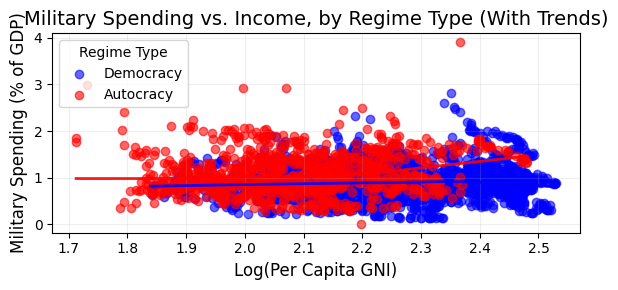

In [14]:

if 'log_GNI' not in df_log.columns:
    df_log['log_GNI'] = np.log1p(df_log['Per_capita_GNI'])  # Log-transform Per_capita_GNI

# Define colors
custom_palette = {
    True: "blue",   # Democracy
    False: "red"  # Autocracy
}

# Plot setup
plt.figure(figsize=(6, 3))

# Scatter points with transparency
for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    plt.scatter(
        subset['log_GNI'],
        subset['military_expenditure'],
        label="Democracy" if democracy else "Autocracy",
        color=custom_palette[democracy],
        alpha=0.6  # Transparency for overlapping points
    )

# Add LOWESS trend lines (non-parametric smoothing)
for democracy in [True, False]:
    subset = df_log[df_log['democracy'] == democracy]
    sns.regplot(
        x=subset['log_GNI'],
        y=subset['military_expenditure'],
        scatter=False,  # Hide scatter points (already plotted)
        line_kws={'lw': 2, 'alpha': 0.9},
        lowess=True,
        color=custom_palette[democracy]
    )

# Final formatting
plt.xlabel("Log(Per Capita GNI)", fontsize=12)
plt.ylabel("Military Spending (% of GDP)", fontsize=12)
plt.title("Military Spending vs. Income, by Regime Type (With Trends)", fontsize=14)
plt.legend(title="Regime Type", fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### Interpretation of Trend Lines
The plot shows:

1. **Autocracies (Red) :**
Flat or Slightly Increasing Trend : Military spending remains high even as income grows. This aligns with Carter’s finding that authoritarian regimes prioritize defense spending for internal control or geopolitical leverage.
Outliers : High-income autocracies (e.g., Saudi Arabia) spend moderately, but most cluster in low-income contexts.
2. **Democracies (Blue) :**
Downward Trend : As income increases, military spending decreases. Wealthier democracies (e.g., Germany, Canada) focus on social welfare over defense.
Exceptions : Some democracies (e.g., Israel) exhibit high spending due to regional security risks.
3. **Trend Lines :** Highlight diverging patterns – democracies prioritize social spending as income grows, while autocracies maintain high defense budgets regardless of income.

### Key Insights
1. Hypothesis Validation :
Hypothesis 2 ("Higher income → lower military spending") holds for democracies but not autocracies.
Autocracies defy this trend, suggesting ideology (not just income) drives defense priorities.
2. Policy Implications :
**Democracies :** Economic growth correlates with reduced militarization.
**Autocracies :** Defense spending is sustained regardless of income, highlighting ideological/rhetorical motives.

## <a id='4'></a>4. Hypothesis

##### **Hypothesis 1:** We would expect higher, the GDP/GNI leader ideologies tend to be more RIGHT. (classification hypothesis)

##### **Hypothesis 2:** We would expect to see a relationship between leader ideologies and military spending while higher income resulting in lower military spending (continuous hypothesis).

##### **Hypothesis 3:** We would expect that higher the development in the country, there will be more Urban population.In addition, we would expect the Urban population is related to ideologies and economy  (count hypothesis).

##### **Hypothesis 4:** We would expect richer, the country more probable to have democracy (binary hypothesis).



## <a id='5'></a>5. Building Predictive Models

## 5.1 GLM Models

### <a id='lm'></a>Linear Model (Multinomial Logistic Regression)

**Goal:** To answer the first hypothesis on leader ideologies:

Accuracy: 0.4789473684210526

Classification Report:
               precision    recall  f1-score   support

    centrist       0.00      0.00      0.00        58
     leftist       0.50      0.56      0.53       267
    rightist       0.46      0.51      0.48       245

    accuracy                           0.48       570
   macro avg       0.32      0.35      0.34       570
weighted avg       0.43      0.48      0.45       570



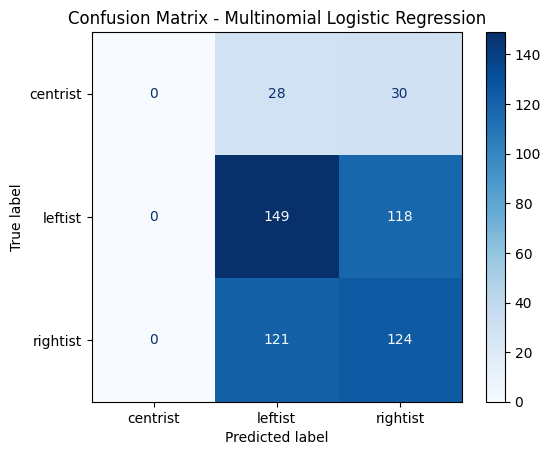

In [ ]:
# 1. Prepare Features and Target
features = [
    'IMF_based_exchange_rate','Per_capita_GNI', 'agriculture_and_hunting_fishing_isic',
    'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation',
    'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'military_expenditure',
    'Urban_population', 'Rural_population'
]
X = df_log[features]
y = df_log['leader_ideology']

# 2. Encode Target Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Remove rows with any NaN in X or y
X = X.copy()
y = y.copy()
not_nan_idx = X.notnull().all(axis=1) & pd.notnull(y)
X = X[not_nan_idx]
y = y[not_nan_idx]


# Combine X and y into a single DataFrame
df_combined = X.copy()
df_combined['leader_ideology'] = y  # Use the original categorical y for now

# Drop rows where any feature or the target is missing
df_combined = df_combined.dropna(axis=0, how='any')

# Separate again
X_clean = df_combined[features]
y_clean = df_combined['leader_ideology']

# Encode target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_clean)


# 3. Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 4. Standardize Predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Fit Multinomial Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# 6. Evaluate the Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Multinomial Logistic Regression")
plt.show()

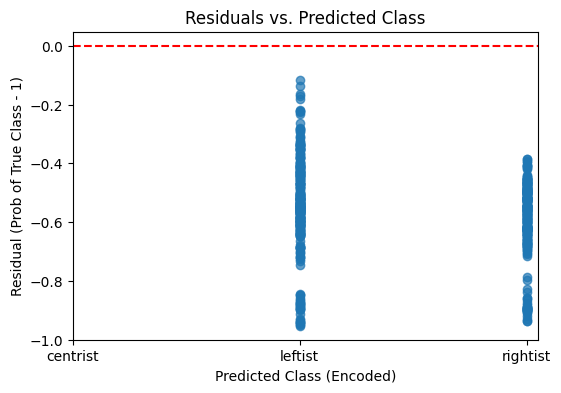

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities
probs = clf.predict_proba(X_test_scaled)
# Residuals: predicted probability for the true class minus 1
residuals = probs[np.arange(len(y_test)), y_test] - 1
# Predicted label (for x-axis)
y_pred = clf.predict(X_test_scaled)

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel('Predicted Class (Encoded)')
plt.ylabel('Residual (Prob of True Class - 1)')
plt.title('Residuals vs. Predicted Class')
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_)
plt.axhline(0, color='red', linestyle='--')
plt.show()

### Multiple Linear Regression 
**Goal**:
- Predict **Urban_population** from leadership ideology, democracy status, per-capita GNI, sector outputs (agriculture, construction, mining, transport), imports, military spending, and GDP. 
- Answer the count hypothesis on urban population.

 **Setup**:  
  - Two pipelines:  
    1. **Scaled** numeric inputs (log-transformed) + one-hot encoded categoricals in a `ColumnTransformer` → `LinearRegression`  
    2. **Unscaled** model for coefficient comparison  
    
**Results**:  
  - **R² Score**: 0.4296  
  - **RMSE**: 50,355,127.90  

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

# --- 1. Make a clean, independent copy of your DataFrame for Linear Regression ---
df_lr = df_log.copy()  # Use your log-transformed DataFrame here

# --- 2. Define features and target ---
lr_features = [
    'leader_ideology',
    'democracy',
    'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic',
    'construction_isic',
    'Imports_of_goods_and_services',
    'mining_manifacturing_isic',
    'transport_storage_communication_isic',
    'military_expenditure',
    'GDP'
]
lr_target = 'Urban_population'

# --- 3. Clean data (drop NA for X and y) ---
df_lr_clean = df_lr[lr_features + [lr_target]].dropna()

# --- 4. Define X and y ---
X_lr = df_lr_clean[lr_features]
y_lr = df_lr_clean[lr_target]

# --- 5. Split into train and test sets ---
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

# --- 6. Categorical and numeric features ---
lr_categorical_features = ['leader_ideology', 'democracy']
lr_numeric_features = [f for f in lr_features if f not in lr_categorical_features]

# --- MODEL 1: SCALED MODEL (Log features used) ---
preprocessor_lr_scaled = ColumnTransformer([
    ('num', StandardScaler(), lr_numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), lr_categorical_features)
])

pipeline_lr_scaled = Pipeline([
    ('preprocessor', preprocessor_lr_scaled),
    ('regressor', LinearRegression())
])

pipeline_lr_scaled.fit(X_lr_train, y_lr_train)
y_lr_pred_scaled = pipeline_lr_scaled.predict(X_lr_test)

# Get feature names after scaling
lr_feature_names = pipeline_lr_scaled.named_steps['preprocessor'].get_feature_names_out()
lr_scaled_coefs = pipeline_lr_scaled.named_steps['regressor'].coef_

# --- MODEL 2: UNSCALED MODEL ---
# One-hot encode categoricals
X_lr_train_unscaled = pd.get_dummies(X_lr_train, columns=lr_categorical_features, drop_first=False)
X_lr_test_unscaled = pd.get_dummies(X_lr_test, columns=lr_categorical_features, drop_first=False)
X_lr_test_unscaled = X_lr_test_unscaled.reindex(columns=X_lr_train_unscaled.columns, fill_value=0)

lr_unscaled = LinearRegression()
lr_unscaled.fit(X_lr_train_unscaled, y_lr_train)
lr_unscaled_coefs = lr_unscaled.coef_

# Make sure the lengths match for comparison
assert len(lr_feature_names) == len(lr_unscaled_coefs), "Mismatch in feature count!"

# --- COEFFICIENT COMPARISON ---
coefficients_lr_df = pd.DataFrame({
    'Feature': lr_feature_names,
    'Coefficient_Unscaled': lr_unscaled_coefs,
    'Coefficient_Scaled': lr_scaled_coefs
}).sort_values(by='Coefficient_Unscaled', key=abs, ascending=False)

from IPython.display import display
display(coefficients_lr_df)

# Calculate R² score and RMSE for the scaled model
r2_lr = r2_score(y_lr_test, y_lr_pred_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_lr_test, y_lr_pred_scaled))

print(f"R² Score: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")

,Feature,Coefficient_Unscaled,Coefficient_Scaled
0,num__Per_capita_GNI,-0.744909,-1.192781
7,num__GDP,0.579750,1.243232
5,num__transport_storage_communication_isic,0.274381,0.620187
4,num__mining_manifacturing_isic,0.199264,0.446531
6,num__military_expenditure,0.129455,0.051236
3,num__Imports_of_goods_and_services,-0.093358,-0.188559
11,cat__democracy_False,-0.056004,-0.056004
12,cat__democracy_True,0.056004,0.056004
8,cat__leader_ideology_centrist,0.025294,0.025294
10,cat__leader_ideology_rightist,-0.014556,-0.014556


R² Score: 0.9635
RMSE: 0.2987


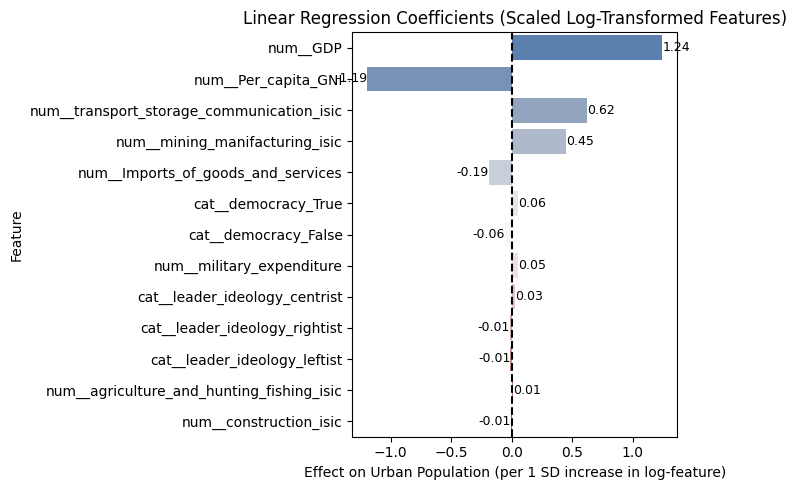

In [18]:

# Ensure columns are correctly named
coefficients_lr_df.columns = ['Feature', 'Unscaled Coef', 'Scaled Coef']

# Sort by absolute value of scaled coefficient for better visualization
coefficients_lr_df = coefficients_lr_df.reindex(coefficients_lr_df['Scaled Coef'].abs().sort_values(ascending=False).index)

plt.figure(figsize=(7, 5))
sns.barplot(
    x='Scaled Coef',
    y='Feature',
    data=coefficients_lr_df,
    palette="vlag"
)
plt.title("Linear Regression Coefficients (Scaled Log-Transformed Features)")
plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Effect on Urban Population (per 1 SD increase in log-feature)")
plt.ylabel("Feature")

# Optional: Annotate each bar with the coefficient value
for i, (coef, feature) in enumerate(zip(coefficients_lr_df['Scaled Coef'], coefficients_lr_df['Feature'])):
    plt.text(
        coef, i, f'{coef:.2f}',
        va='center',
        ha='left' if coef > 0 else 'right',
        color='black',
        fontsize=9
    )

plt.tight_layout()
plt.show()

We trained two linear models (unscaled and scaled) and both give the same R² and RMSE. Scaling just makes the numbers easier to compare.

| Feature                             | Scaled Coefficient | What It Means                                                                         |
|-------------------------------------|-------------------:|---------------------------------------------------------------------------------------|
| **GDP**                             | +1.243             | A one-SD rise in log(GDP) raises log(urban pop) by 1.243. It is the strongest driver. |
| **Per Capita GNI**                  | –1.193             | A one-SD rise in log(GNI) lowers log(urban pop) by 1.193.                             |
| **Transport & Communication (ISIC)**| +0.620             | More transport activity links to larger cities.                                       |
| **Mining & Manufacturing (ISIC)**   | +0.447             | More industry goes hand-in-hand with bigger urban centers.                            |
| **Military Expenditure**            | +0.051             | A small positive tie to city size.                                                    |
| **Imports of Goods & Services**     | –0.189             | Slight negative link, perhaps trade is stronger outside big cities.                   |
| **Democracy (True vs False)**       | +0.056             | Democracies have about 6% more urban population (log scale).                          |
| **Leader Ideology: Centrist**       | +0.025             | Centrist governments show a small boost in urban growth.                              |
| **Leader Ideology: Rightist**       | –0.015             | Right-leaning regimes have a slight negative effect on city size.                     |
| **Leader Ideology: Leftist**        | –0.011             | Left-leaning regimes have a tiny negative effect on city size.                        |
| **Agriculture & Fishing (ISIC)**    | +0.010             | Very small positive link, maybe farm towns near cities.                               |
| **Construction (ISIC)**             | –0.007             | Nearly zero effect once other factors are in the model.                               |

**Overall Fit**  
- **R² = 0.9635**: We explain about 96% of the differences in log urban population.  
- **RMSE = 0.2987**: On the log scale, predictions are off by about 0.3 on average (roughly ±35% in real counts).

**Project Observations**  
- **GDP** is the biggest driver of city size.  
- **Per capita GNI** has a strong negative effect once GDP is fixed.  
- **Political factors** (democracy, ideology) matter, but much less than economy.  
- **Scaling** helps us compare all effects on the same footing.


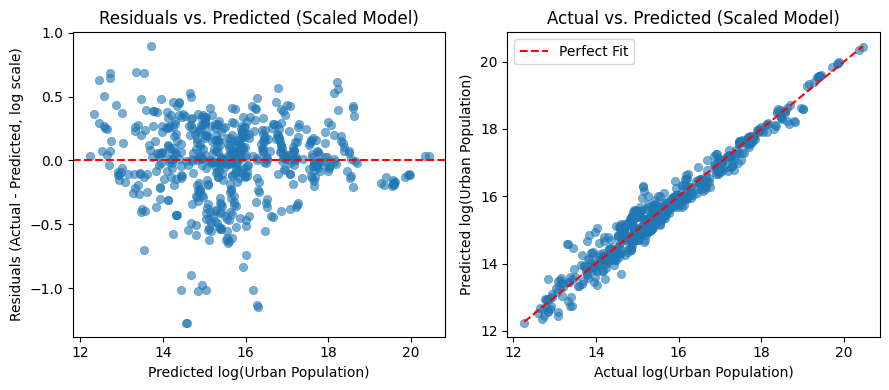

In [19]:

# Calculate residuals using unique variables
residuals_lr = y_lr_test - y_lr_pred_scaled

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# --- Plot 1: Residuals vs. Predicted ---
sns.scatterplot(x=y_lr_pred_scaled, y=residuals_lr, alpha=0.6, ax=axes[0], edgecolor=None)
axes[0].axhline(0, color='red', linestyle='--')  # Horizontal line at y=0
axes[0].set_title("Residuals vs. Predicted (Scaled Model)")
axes[0].set_xlabel("Predicted log(Urban Population)")
axes[0].set_ylabel("Residuals (Actual - Predicted, log scale)")

# --- Plot 2: Actual vs. Predicted ---
sns.scatterplot(x=y_lr_test, y=y_lr_pred_scaled, alpha=0.6, ax=axes[1], edgecolor=None)
axes[1].plot([y_lr_test.min(), y_lr_test.max()], [y_lr_test.min(), y_lr_test.max()],
             color='red', linestyle='--', label='Perfect Fit')  # Diagonal line (perfect fit)
axes[1].set_title("Actual vs. Predicted (Scaled Model)")
axes[1].set_xlabel("Actual log(Urban Population)")
axes[1].set_ylabel("Predicted log(Urban Population)")
axes[1].legend()

plt.tight_layout()
plt.show()

### Plot Interpretation

- **Residuals vs. Predicted**  
  The dots scatter above and below the red line at zero, with no clear curve or trend. That means our errors stay fairly even across all predictions. In simple terms, the model does not seem to miss big groups of data in one direction or another.

- **Actual vs. Predicted**  
  Most points lie close to the dashed “perfect fit” line. This shows our predictions match the true values very well. Small gaps at the top or bottom are normal, but overall the model tracks reality closely.


### Partial Dependence & Interaction Effects

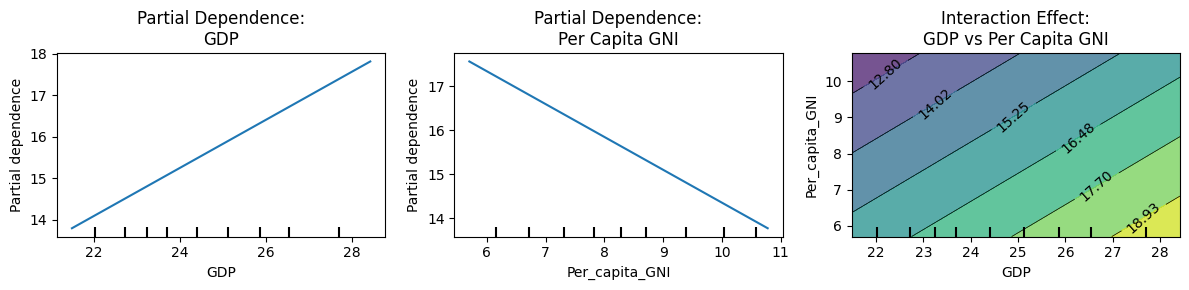

In [20]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of individual features and their interaction tuple
features = ['GDP', 'Per_capita_GNI']
interaction = ('GDP', 'Per_capita_GNI')

# Create a figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# 1) Partial Dependence for GDP
PartialDependenceDisplay.from_estimator(
    pipeline_lr_scaled,  # your pipeline (preprocessor + LinearRegression)
    X_lr_train,          # raw training DataFrame
    [features[0]],       # must match column names in X_lr_train
    ax=axes[0]
)
axes[0].set_title("Partial Dependence:\nGDP")

# 2) Partial Dependence for Per Capita GNI
PartialDependenceDisplay.from_estimator(
    pipeline_lr_scaled,
    X_lr_train,
    [features[1]],
    ax=axes[1]
)
axes[1].set_title("Partial Dependence:\nPer Capita GNI")

# 3) 2D Interaction between GDP and Per Capita GNI
PartialDependenceDisplay.from_estimator(
    pipeline_lr_scaled,
    X_lr_train,
    [interaction],
    ax=axes[2],
    kind='average',
    grid_resolution=30
)
axes[2].set_title("Interaction Effect:\nGDP vs Per Capita GNI")

plt.tight_layout()
plt.show()

### Plots Interpretation

1. **GDP Drives Urban Population Up**  
   - The first plot shows a clear, almost straight-line rise: as log(GDP) goes up, log(Urban Population) goes up.  
   - This confirms GDP is a strong, consistently positive predictor of city size.

2. **Per-Capita GNI Pushes Urban Share Down**  
   - The second plot slopes downward: higher log(Per-Capita GNI) is associated with lower log(Urban Population).  
   - In our data, wealthier individuals (relative to population) tend to live outside large urban centers, once GDP is already accounted for.

3. **Minimal Interaction — Mostly Additive Effects**  
   - The contour plot is nearly linear diagonal: each variable’s effect on its own largely adds up.  
   - You see the highest urban levels only where **both** GDP is high **and** Per-Capita GNI is low-to-moderate.  
   - There’s no strong “bend” or non-parallel lines, so an additive model (like our linear regression) is appropriate.


## 5.2 GLM Models


### 5.2.1 Binomial Model

**Goal**: Answer the hypothesis on binary variable democracy.

In [21]:
from statsmodels.formula.api import glm

import statsmodels.api as sm

In [22]:
df_log_new = df_log.copy().dropna()

columns_to_work_with = [
    'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic',
    'construction_isic',
    'Imports_of_goods_and_services',
    'mining_manifacturing_isic',
    'transport_storage_communication_isic',
    'GDP',
    'Urban_population',
    'leader_ideology',
    'democracy',
    'military_expenditure'
]
df_log_new = df_log_new[columns_to_work_with]

***MLP Classifier must deal with the dataset of numeric types.   
So we updated the new dataframe, where for real value of string(object) type, we set a numeric equivalent for all the columns we use.***

In [23]:
df_log_new.dtypes

Per_capita_GNI                          float64
agriculture_and_hunting_fishing_isic    float64
construction_isic                       float64
Imports_of_goods_and_services           float64
mining_manifacturing_isic               float64
transport_storage_communication_isic    float64
GDP                                     float64
Urban_population                        float64
leader_ideology                          object
democracy                                  bool
military_expenditure                    float64
dtype: object

In [24]:
column_mapper_dict = {}
for column in df_log_new.columns:
    if df_log_new[column].dtype == 'object':
        unique_vals = df_log_new[column].unique()
        column_mapper_dict[column] = {val: i for i, val in enumerate(unique_vals)}

        df_log_new[column] = df_log_new[column].map(column_mapper_dict[column])



In [25]:
column_mapper_dict

{'leader_ideology': {'leftist': 0, 'rightist': 1, 'centrist': 2}}

In [26]:
df_log_new.head()

,Per_capita_GNI,agriculture_and_hunting_fishing_isic,construction_isic,Imports_of_goods_and_services,mining_manifacturing_isic,transport_storage_communication_isic,GDP,Urban_population,leader_ideology,democracy,military_expenditure
0,6.480045,20.611193,19.143951,19.995287,20.576130,17.211963,21.486756,13.995515,0,False,1.929824
1,6.908755,20.875997,19.243972,20.870420,19.608819,18.554771,21.886305,14.039069,1,False,0.866693
2,6.551080,20.369060,19.089738,20.580941,19.151297,18.441577,21.522867,14.046952,0,False,0.825526
3,6.703188,20.415971,19.024759,20.749794,19.158498,18.780213,21.661267,14.054697,0,False,0.805691
4,6.936343,20.542967,19.437968,20.908941,19.361398,19.107368,21.893166,14.062257,0,False,0.810579


We split the dataset into train and test for explanatory and target variables. Thene we fit a binomial model on our target variable democracy. 

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('democracy',axis=1), df_log_new['democracy'],
    test_size=0.2, random_state=1
)

In [28]:
predictors = '+'.join([col for col in X_train.columns])

binomial_glm = glm(
    f'democracy ~ {predictors}',
    data=df_log_new.loc[X_train.index],
    family=sm.families.Binomial(),
)


In [29]:
binomial_glm_res = binomial_glm.fit()

In [30]:
binomial_glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Generalized Linear Model Regression Results                            
===================================================================================================
Dep. Variable:     ['democracy[False]', 'democracy[True]']   No. Observations:                 2270
Model:                                                 GLM   Df Residuals:                     2259
Model Family:                                     Binomial   Df Model:                           10
Link Function:                                       Logit   Scale:                          1.0000
Method:                                               IRLS   Log-Likelihood:                -981.18
Date:                                     Sat, 24 May 2025   Deviance:                       1962.4
Time:                                             18:33:46   Pearson chi2:                 1.88e+03
No. Iterations:                                          6   Pseudo R-squ. (CS):             0.3371
Covariance Type:                                 nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                5.9928      1.313      4.564      0.000       3.419       8.567
Per_capita_GNI                          -1.9419      0.156    -12.418      0.000      -2.248      -1.635
agriculture_and_hunting_fishing_isic    -0.0123      0.104     -0.119      0.905      -0.216       0.191
construction_isic                        0.1609      0.116      1.387      0.165      -0.066       0.388
Imports_of_goods_and_services            0.6899      0.148      4.662      0.000       0.400       0.980
mining_manifacturing_isic                1.1788      0.161      7.321      0.000       0.863       1.494
transport_storage_communication_isic     0.5848      0.175      3.350      0.001       0.243       0.927
GDP                                     -1.5700      0.359     -4.378      0.000      -2.273      -0.867
Urban_population                        -0.8480      0.171     -4.972      0.000      -1.182      -0.514
leader_ideology                         -0.1752      0.089     -1.966      0.049      -0.350      -0.001
military_expenditure                     1.5641      0.156     10.036      0.000       1.259       1.870
========================================================================================================
"""

In [31]:
y_pred_probes = binomial_glm_res.predict(X_test)

In [32]:
y_pred = (y_pred_probes >= 0.5).astype(int)

In [33]:
cm = confusion_matrix(Y_test, y_pred)

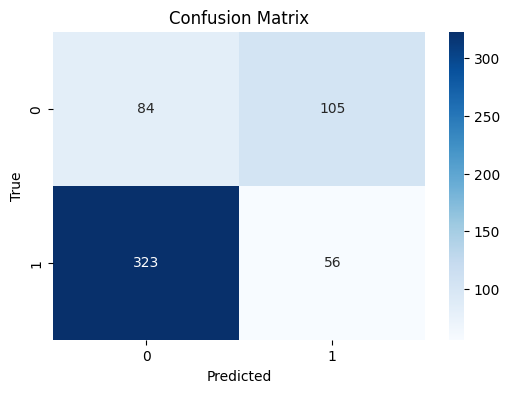

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [35]:
accuracy_score(Y_test,y_pred)

0.24647887323943662

In [36]:
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

       False       0.21      0.44      0.28       189
        True       0.35      0.15      0.21       379

    accuracy                           0.25       568
   macro avg       0.28      0.30      0.24       568
weighted avg       0.30      0.25      0.23       568



***Let's drop couple of features which are not significant, and few which can potentially cause collinearity. The dropped non significant columns are agriculture, construction and leader ideology.
and build an updated model***

In [37]:
non_significant_columns_per_p = ['agriculture_and_hunting_fishing_isic', 'construction_isic', 'leader_ideology']
X_reduce_train = X_train.drop(columns=non_significant_columns_per_p)
predictors = '+'.join([col for col in X_reduce_train.columns])

binomial_gam = glm(
    f'democracy ~ {predictors}',
    data=df_log_new.drop(columns=non_significant_columns_per_p).loc[X_reduce_train.index],
    family=sm.families.Binomial(),
)


In [38]:
binomial_glm_res = binomial_gam.fit()

In [39]:
binomial_glm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Generalized Linear Model Regression Results                            
===================================================================================================
Dep. Variable:     ['democracy[False]', 'democracy[True]']   No. Observations:                 2270
Model:                                                 GLM   Df Residuals:                     2262
Model Family:                                     Binomial   Df Model:                            7
Link Function:                                       Logit   Scale:                          1.0000
Method:                                               IRLS   Log-Likelihood:                -983.99
Date:                                     Sat, 24 May 2025   Deviance:                       1968.0
Time:                                             18:33:46   Pearson chi2:                 1.89e+03
No. Iterations:                                          6   Pseudo R-squ. (CS):             0.3355
Covariance Type:                                 nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                5.2057      1.185      4.392      0.000       2.883       7.529
Per_capita_GNI                          -1.9321      0.141    -13.661      0.000      -2.209      -1.655
Imports_of_goods_and_services            0.7282      0.142      5.124      0.000       0.450       1.007
mining_manifacturing_isic                1.1603      0.158      7.335      0.000       0.850       1.470
transport_storage_communication_isic     0.5948      0.172      3.460      0.001       0.258       0.932
GDP                                     -1.4398      0.282     -5.112      0.000      -1.992      -0.888
Urban_population                        -0.8552      0.170     -5.035      0.000      -1.188      -0.522
military_expenditure                     1.5797      0.151     10.479      0.000       1.284       1.875
========================================================================================================
"""

In [40]:
np.exp(binomial_glm_res.params['Per_capita_GNI'])

0.14483979804029234

In [41]:
np.exp(binomial_glm_res.params['military_expenditure'])

4.853567289745277

***
***Model interpretation***  

Statistically-wise, we see a better features chosen, as all of them are significant now.  
Pseudo R-squ. (CS) parameter tells us, that almost 33% of the variation are explained by the model.   
We can interpret coefficients of our model.  
For binary / binomial models to interpret coefficients properly, 
we need to get an exponential form of each coefficient, because by default, the activation function is logarithmic, 
and we need to take inverse of it.  

Let's start from the largest coefficient - Per_capita_GNI feature.  
A one-unit increase in this feature, leads to almost 7 times increase in an odds ratio for entry to be democratic,  
once other features are constant.  
An opposite example - military_expenditure feature.  
A one-unit increase leads to 21% decrease in an odds ratio for entry to be democratic.  
Here we can stop interpreting coefficients, as it will be the same explanation.  
To have a general look on features coefficients and there affect, I'll build a related plot below
***

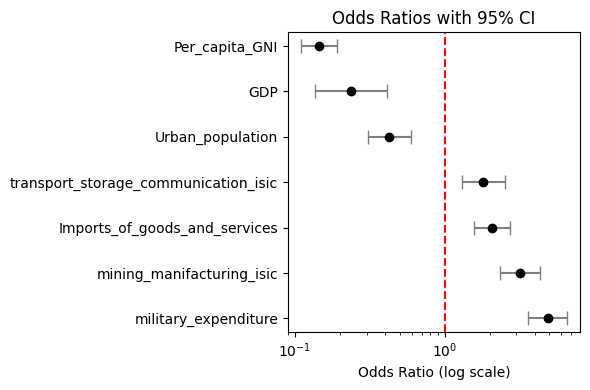

In [42]:


# Get coefficients and confidence intervals
coefs = binomial_glm_res.params.drop(['Intercept'])
conf = binomial_glm_res.conf_int().drop(['Intercept'])
conf.columns = ['2.5%', '97.5%']

# Compute odds ratios and CI
odds_ratios = np.exp(coefs)
conf_exp = np.exp(conf)

# Create a DataFrame
or_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    '2.5%': conf_exp['2.5%'],
    '97.5%': conf_exp['97.5%']
}).sort_values(by='Odds Ratio', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
plt.errorbar(or_df['Odds Ratio'], or_df.index,
             xerr=[or_df['Odds Ratio'] - or_df['2.5%'],
                   or_df['97.5%'] - or_df['Odds Ratio']],
             fmt='o', color='black', ecolor='gray', capsize=5)
plt.axvline(1, color='red', linestyle='--')
plt.xlabel("Odds Ratio (log scale)")
plt.xscale('log')
plt.title("Odds Ratios with 95% CI")
plt.tight_layout()
plt.show()

***Evaluate model performance***

In [43]:
y_pred_probes = binomial_glm_res.predict(X_test.drop(columns=non_significant_columns_per_p))


In [44]:
y_pred = (y_pred_probes >= 0.5).astype(int)

In [45]:
cm = confusion_matrix(Y_test, y_pred)

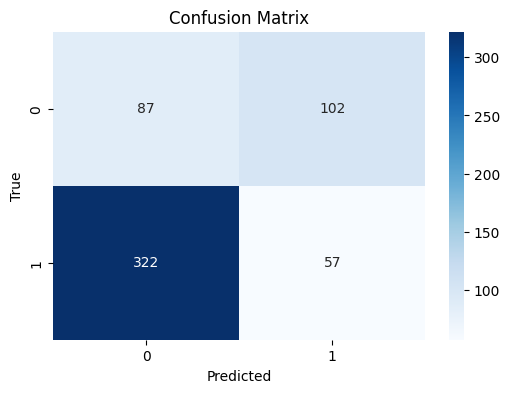

In [46]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [47]:
accuracy_score(Y_test, y_pred)

0.2535211267605634

In [48]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       0.21      0.46      0.29       189
        True       0.36      0.15      0.21       379

    accuracy                           0.25       568
   macro avg       0.29      0.31      0.25       568
weighted avg       0.31      0.25      0.24       568



In [49]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auci = auc(fpr, tpr)

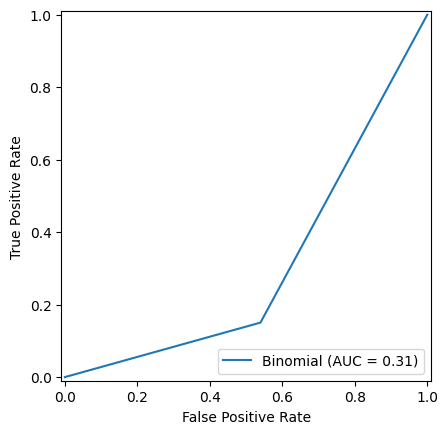

In [50]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auci, estimator_name = 'Binomial')
display.plot()

***From the above results, we have confirmed that the model has quite good performance.  
In term of simplicity of the model and clear understanding of how features influence the response variable, 
it might be a good choice to use, if there's not such a goal to have as high accuracy as possible***

### 5.2.2 Poisson Model:

**Goal**: To answer the count hypothesis on Urban population.

**Setup**: The data is split into train and test dataset, keeping the variables of interest as explanatory features and our target variable Y as Urban population.

           1- Quasi-poisson Model

           2- Negative binomial Model

**Results**: Pseudo R2 (NB Model):~ 0.68, RMSE (NB Model):~ 10158405

In [112]:
# Train-Test Split
df_log['Urban_population'] = np.exp(df_log['Urban_population'])

#print(df_log['Urban_population'] )

X_train, X_test, y_train, y_test = train_test_split(
    df_log.drop(columns='Urban_population'),  # predictors
    df_log['Urban_population'],               # target
    test_size=0.2,                            # 20% test data
    random_state=42                           # for reproducibility
)





In [113]:
# Recombine X and y into one training DataFrame
train_data = X_train.copy()
train_data['Urban_population'] = y_train
#print(train_data)




There is overdispersion so we use quasipoisson model:

In [114]:
formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP'
qp_model = smf.glm(formula=formula, data=train_data, family=sm.families.Poisson()).fit(scale='dev')  # 'X2' enables quasi-poisson estimation
summary=qp_model.summary()
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{summary}</pre>"))

| Variable                                | Effect (exp(Coeff)) | Interpretation                                                                                          | Significance (P-value) |
|----------------------------------------|---------------------|------------------------------------------------------------------------------------------------------|-----------------------|
| **Intercept**                          | 0.2672              | Baseline expected urban population when all predictors are at reference levels (no democracy, etc.)  | —                     |
| **Leader Ideology (rightist)**         | 0.9755              | ~2.45% lower urban population vs. centrist/leftist leaders                                           | 0.031 (significant)   |
| **Democracy**                         | 1.0553              | ~5.53% higher urban population in democracies                                                        | 0.000 (significant)   |
| **Per Capita GNI**                    | 0.4875              | ~51.25% decrease per unit increase; wealthier countries tend to lower urban population growth        | 0.000 (significant)   |
| **Construction Sector**               | 0.9701              | ~2.99% lower urban population per unit increase in construction, small but significant effect                                     | 0.014 (significant)   |
| **Imports of Goods and Services**    | 0.8546              | ~14.54% decrease per unit increase; higher imports linked to lower urban population growth          | 0.000 (significant)   |
| **Mining and Manufacturing Sector**  | 1.2773              | ~27.73% increase per unit increase; positive relationship with urban population growth               | 0.000 (significant)   |
| **Military Expenditure**              | 0.9575              | ~4.25% decrease per unit increase; significant negative effect                                       | 0.000 (significant)   |
| **GDP**                              | 2.4940              | ~149.40% increase per unit increase; strong positive link to urban population growth                 | 0.000 (significant)   |
| **Leader Ideology (leftist)**         | 0.9929              | Very small effect; statistically not significant                                                     | 0.557 (not significant)|
| **Agriculture, Hunting, and Fishing** | 0.9857              | No significant impact on urban population growth                                                     | 0.130 (not significant)|
| **Transport, Storage, and Communication** | 0.9808          | Small, non-significant effect                                                                        | 0.281 (not significant)|

---

### Summary

Urban population growth is more pronounced in wealthier countries (higher GDP) and those with more mining/manufacturing activity. Democracies tend to have slightly larger urban populations. Conversely, higher military spending, right wing leaders and imports correlate with reduced urban population growth.


Now we will check the residual plots:

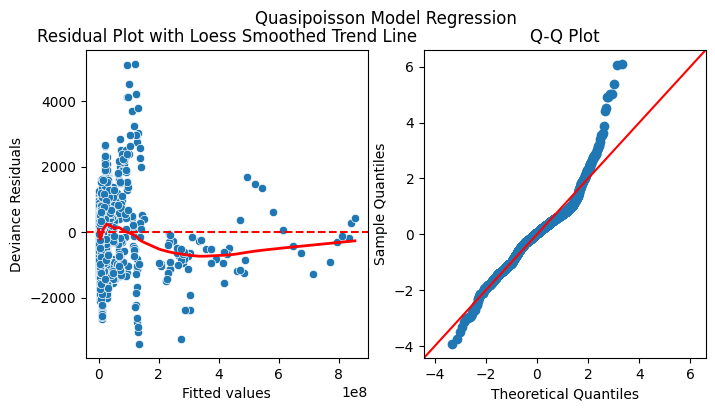

In [115]:

# Deviance residuals
deviance_residuals = qp_model.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# Add an overall title
plt.suptitle('Quasipoisson Model Regression')

# Residual plot
sns.scatterplot(x=qp_model.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, qp_model.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

#plt.tight_layout()

plt.show()

The residual plots show overdispersion and heteroscedasticity. Negative binomial might be a better approach. For the Negative binomial Model, alpha is calculated using MLE approach from quasipoisson model using R.

In [116]:

formula = 'Urban_population ~ leader_ideology + democracy  + Per_capita_GNI + agriculture_and_hunting_fishing_isic +construction_isic  + Imports_of_goods_and_services + mining_manifacturing_isic + transport_storage_communication_isic  + military_expenditure + GDP '

model_nb = smf.glm(
    formula=formula,
    data=train_data,  # your cleaned dataframe
    family=sm.families.NegativeBinomial(alpha=2.43)
).fit()

result_nb = model_nb
summary=result_nb.summary()
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{summary}</pre>"))

| Variable                                | Coefficient (exp)         | Interpretation                                                                                                                                          | Significant (P-value) |
|-----------------------------------------|----------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------|
| **Intercept**                           | exp(-0.9069) = 0.4049      | The baseline expected urban population.                                                                                                                 | No (0.219)             |
| **Per Capita GNI**                      | exp(-0.7498) = 0.4721      | A 1-unit increase is associated with a 52.79% decrease in expected urban population. Wealthier countries tend to have lower urban population growth.     | **0.000(significant)**        |
| **Mining & Manufacturing Sector**       | exp(0.1836) = 1.2012       | A 1-unit increase is associated with a 20.12% increase in expected urban population. Suggests such activity drives higher urban growth.                  | **0.041 (significant)**        |
| **Transport, Storage & Communication**  | exp(0.2557) = 1.2912       | A 1-unit increase is associated with a 29.12% increase in expected urban population. Indicates more activity leads to greater urban population growth.    | **0.017 (significant)**        |
| **GDP**                                 | exp(0.6225) = 1.8647       | A 1-unit increase is associated with an 86.47% increase in expected urban population. Wealthier countries tend to have larger urban populations.          | **0.002 (significant)**        |
| **Leader Ideology (Leftist)**           | exp(-0.0432) = 0.9574      |  No substantial evidence that leftist leadership affects urban population growth.                                          | 0.703(not significant)             |
| **Leader Ideology (Rightist)**          | exp(-0.0535) = 0.9477      | No substantial evidence that rightist leadership affects urban population growth.                                         | 0.640 (not significant)             |
| **Democracy**                           | exp(0.0948) = 1.0995       |  Democracies do not show a strong effect on urban population compared to non-democracies.                                  | 0.26(not significant)             |
| **Agriculture, Hunting & Fishing**      | exp(0.0002) = 1.0002       | This sector has no meaningful impact on urban population growth.                                                          | 0.998 (not significant)            |
| **Construction Sector**                 | exp(-0.0017) = 0.9983      |  Consstruction sector does not meaningfully relate to urban population growth in the model.                                         | 0.982 (not significant)            |
| **Imports of Goods and Services**       | exp(-0.1053) = 0.8994      | No clear evidence that imports are linked to changes in urban population growth.                                          | 0.222 (not significant)             |
| **Military Expenditure**                | exp(0.1170) = 1.1238       | Though the effect is positive, it does not have a strong relationship with urban population growth.                       | 0.189 (not significant)            |

### Summary:
Wealthier countries, particularly those with higher GDP, tend to have larger urban populations, though higher per capita GNI relate to slower urban growth. This might mean that, richer the individuals, they prefer to live in the countryside rather than in the cities even though the country is more developed. Significant increases in urban population are observed in countries with more activity in the mining, manufacturing, and transport sectors. Political leadership and sectors like agriculture, construction, imports, and military spending do not show strong or significant effects.



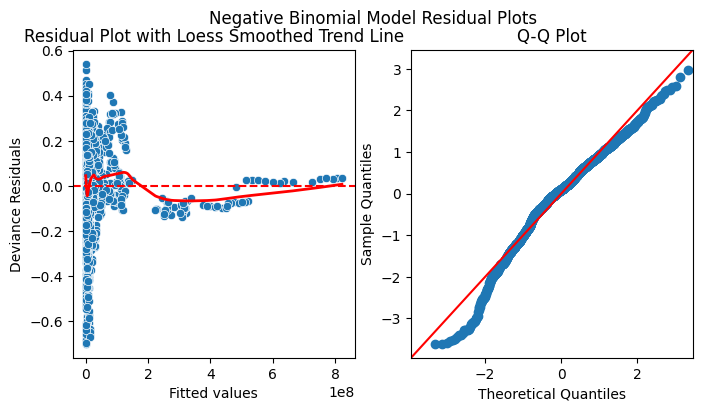

In [117]:

# Deviance residuals
deviance_residuals = model_nb.resid_deviance

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# Add an overall title
plt.suptitle('Negative Binomial Model Residual Plots')

# Residual plot
sns.scatterplot(x=model_nb.fittedvalues, y=deviance_residuals, ax=ax[0])

# Add a smoothed trend line
try:
    loess = sm.nonparametric.lowess(deviance_residuals, model_nb.fittedvalues, frac=0.6)
    ax[0].plot(loess[:, 0], loess[:, 1], color='red', linewidth=2)
except Exception as e:
    print(f"Could not create LOWESS line: {e}")

ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_title('Residual Plot with Loess Smoothed Trend Line')

# Q-Q Plot
sm.qqplot(deviance_residuals, line='45', fit=True, ax=ax[1])
ax[1].set_xlabel('Theoretical Quantiles')
ax[1].set_ylabel('Sample Quantiles')
ax[1].set_title('Q-Q Plot')

#plt.tight_layout()

plt.show()

Negative binomial model seems to be a better fit. QQplot is close to being flat while still having some irregularities in left tail and fitted vs residuals dispersed randomly around 0 (Fitted value scale is 1e8)

RMSE: 9807909.3857


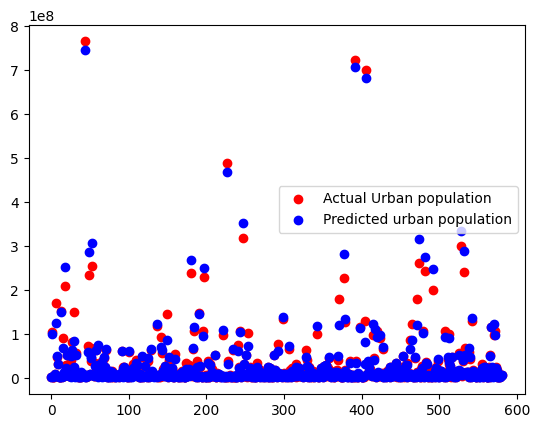

In [119]:
y_pred = model_nb.predict(X_test)

figsize=(3, 2)
plt.scatter(range(len(y_test)), y_test, color='red')
plt.scatter(range(len(y_pred)), y_pred, color='blue')
plt.legend(['Actual Urban population', 'Predicted urban population'])
# Convert both to numeric (if not already)
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred, errors='coerce')

# Drop rows where either is NaN
valid_indices = (~y_test_numeric.isna()) & (~y_pred_numeric.isna())

# Filter only valid rows
y_test_clean = y_test_numeric[valid_indices]
y_pred_clean = y_pred_numeric[valid_indices]

# Now compute RMSE
from sklearn.metrics import mean_squared_error

rmse= np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
print(f"RMSE: {rmse:.4f}")


The predicted vs actual values seem to correspond to each other in our visual check while being slightly off. RMSE seems quite high but we are in 1e8 range so looks reasonable.

## 5.3 Generalized Additive Models

**Goal:** To answer the continuous hypothesis on military expenditure.

For GAM's we first tried to use pyGAM package. However, this package does not use maximum likelihood methods and p-values should be approached with caution. Below there is the snippet of python approach. To be able to interpret our results we used R's mgcv package with the same model and imported the results to this jupyter notebook. We will interpret the results from R that used REML method.


**Setup:**
The data is split to train and test, military expenditure being the target variable.
1-Python pyGAM

2-R mgcv

3- Yeo-johnson transformed response variable with mgcv 

**Results:**  
R2-adjusted (Yeo-Johnson transformed GAM): 0.352 , RMSE (Yeo-Johnson transformed GAM): 0.3306554


In [58]:
selected_cols = ['Per_capita_GNI', 'agriculture_and_hunting_fishing_isic', 'construction_isic','transport_storage_communication_isic', 'Imports_of_goods_and_services', 'mining_manifacturing_isic', 'GDP', 'military_expenditure', 'Urban_population']
df_log_a=df_log.copy().dropna(subset=['Urban_population'])

X_train, X_test, y_train, y_test = train_test_split(
    df_log_a.drop(columns='military_expenditure'),  # predictors
    df_log_a['military_expenditure'],               # target
    test_size=0.2,                            # 20% test data
    random_state=42                           # for reproducibility
)


# Recombine X and y into one training DataFrame
train_data = X_train.copy()
train_data['military_expenditure'] = y_train
#print(train_data)

First, we fit a quadratic polynomial model. We hypothesize that some of the variables with military_expenditure can have a non-linear relationship regarding their distributions we plotted in the EDA.

In [59]:
# Map variable names to column indices in X_train
name_to_idx = {name: i for i, name in enumerate(X_train.columns)}

# Assume your dataset is called df
model = smf.ols(formula='''
military_expenditure ~ leader_ideology + democracy
+ Per_capita_GNI +
+ I(agriculture_and_hunting_fishing_isic*2)
+ I(construction_isic*2)
+ I(Imports_of_goods_and_services*2)
+ I(mining_manifacturing_isic*2)
+ Urban_population
+ I(GDP*2)
''', data=train_data).fit()

summary=model.summary()
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{summary}</pre>"))


In the quadratic model democracy,GNI,agriculture,imports,GDP and urban population are significant. Rsquared is low.  We would like to fit a GAM model for better adjustments for non linearities.

We need to have all the variables values in float or int format for pyGAM. We achieve this by using one hot encoding.

In [60]:
df_log_b=df_log.copy().dropna(subset=['Urban_population'])
cols = [
    'Per_capita_GNI',
    'agriculture_and_hunting_fishing_isic',
    'construction_isic',
    'Imports_of_goods_and_services',
    'mining_manifacturing_isic',
    'transport_storage_communication_isic',
    'GDP',
    'Urban_population',
    'leader_ideology',
    'democracy']
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_log_b.drop(columns='military_expenditure'),
    df_log_b['military_expenditure'],
    test_size=0.2,
    random_state=42
)
X_train_sel = X_train[cols].copy()
X_test_sel = X_test[cols].copy()

X_train_sel['Urban_population_log'] = np.log1p(X_train_sel['Urban_population'])
X_test_sel['Urban_population_log'] = np.log1p(X_test_sel['Urban_population'])

X_train_sel = X_train_sel.drop(columns=['Urban_population'])
X_test_sel = X_test_sel.drop(columns=['Urban_population'])

# One-hot encode categorical columns on train
X_train_encoded = pd.get_dummies(
    X_train_sel,
    columns=['leader_ideology', 'democracy'],
    drop_first=True,
    dtype=int
)

# One-hot encode categorical columns on test
X_test_encoded = pd.get_dummies(
    X_test_sel,
    columns=['leader_ideology', 'democracy'],
    drop_first=True,
    dtype=int
)

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Replace infinite values with NaN (if any)
X_train_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN in X_train and adjust y_train accordingly
train_mask = X_train_encoded.notnull().all(axis=1)
X_train_encoded = X_train_encoded.loc[train_mask]
y_train = y_train.loc[X_train_encoded.index]

test_mask = X_test_encoded.notnull().all(axis=1)
X_test_encoded = X_test_encoded.loc[test_mask]
y_test = y_test.loc[X_test_encoded.index]

#print(f"Training shape: X={X_train_encoded.shape}, y={y_train.shape}")
#print(f"Test shape: X={X_test_encoded.shape}, y={y_test.shape}")



#X_train_encoded.to_csv('X_enc.csv', index=False)  # Save X DataFrame to a CSV file (no row indices)
#y_train.to_csv('y_train_enc.csv', index=False)  # Save y_train to a CSV file (no row indices)
#y_test.to_csv('y_test_enc.csv', index=False)  # Save y_train to a CSV file (no row indices)
#X_test_encoded.to_csv('x_test_enc.csv', index=False)  # Save y_train to a CSV file (no row indices)


Now, we fit a GAM model with pyGAM.

In [61]:


from pygam import LinearGAM, s, f

# 4) Fit on the cleaned data
gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+s(4)+s(5)+s(6)+s(7)+f(8)+f(9)).fit(X_train_encoded.values, y_train)
#gam.gridsearch(X.values, y)


import io
from contextlib import redirect_stdout
from IPython.display import HTML, display

# Capture the printed summary into a string
buf = io.StringIO()
with redirect_stdout(buf):
    gam.summary()
summary_text = buf.getvalue()

# Display in smaller font
display(HTML(f"<pre style='font-size:12px'>{summary_text}</pre>"))


Since this approach did not use maximum likelihood method and p values should be approached with caution, we fit the GAM model using R mgcv package with REML. 

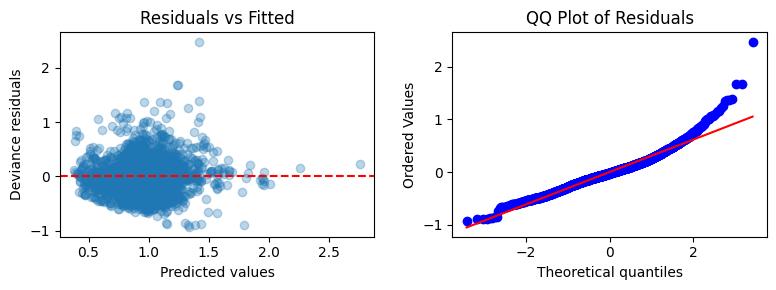

In [62]:

gam.deviance_residuals(X_train_encoded, y_train)
# 1. Residuals plot
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.scatter(gam.predict(X_train_encoded), gam.deviance_residuals(X_train_encoded, y_train), alpha=0.3)
plt.axhline(0, color='r', ls='--')
plt.xlabel("Predicted values")
plt.ylabel("Deviance residuals")
plt.title("Residuals vs Fitted")

# 2. QQ plot
plt.subplot(1, 2, 2)
from scipy.stats import probplot
probplot(gam.deviance_residuals(X_train_encoded, y_train), dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()


In [63]:
# Read and print the model summary
with open("gam_R/gam_model_summary.txt", "r") as f:
    summary_text = f.read()

print("=== GAM Model Summary ===")
summary=summary_text
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{summary}</pre>"))



=== GAM Model Summary ===



**Intercept** is significant and ~1. This shows a ~3 % of GDP is a baseline value for military expenditure when holding all the predictors at 0.

***Continuous predictors:***

All smooth terms are significant and their degrees of freedom are different than 1. This indicates important nonlinear relationships exist with the response variable. Economic indicators have significant non-linear relationships with military expenditure. s(Per_capita_GNI) is the most complex smooth term with the highest degrees of freedom.

***Categorical predictors (parametric terms):***

Rightist leader ideology is not significant. Being rightist does not significantly affect the outcome.
Having a democracy is significant. Democracies tend to have lower values of military expenditure.
Leftist leader ideology is not significant as well. Leader ideologies does not seem to have an effect on military expenditure.


Overall, the model explains ~34.6% of the variability in the data which is not a lot but could be considered okay for social sciences.
Below we check grid plots for each of our variables, to see if they really follow a non-linear relationship with the response variable.


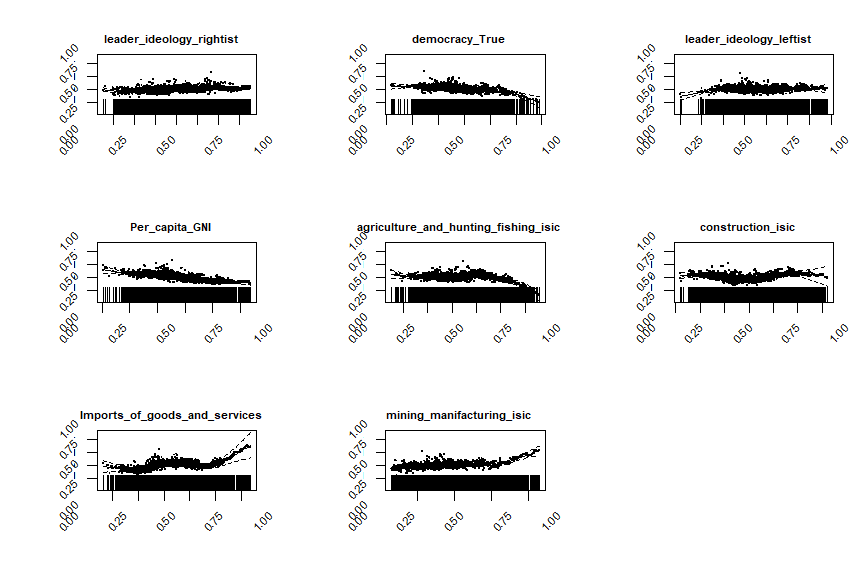

In [64]:
from IPython.display import Image, display

# Make sure the path is correct
display(Image(filename="gam_R/grid_plot.png"))


Here in the graphs, we clearly see that except the first variable, all the variables follow a non-linear relationship and it is captured by our model. However, we also see that variance is higher for couple of variables for higher values.
Now we will check diagnostics for our GAM model:


In [65]:
# Read and print the gam.check diagnostics
with open("gam_R/gam_check_output.txt", "r") as f:
    check_text = f.read()

print("=== GAM Check Diagnostics ===")

summary=check_text
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{summary}</pre>"))

print("RMSE:0.3275406")


=== GAM Check Diagnostics ===


RMSE:0.3275406


The model is stable and most of the terms are fitted well (p values are not significant in model check).

- Urban population has a significant k index, which suggests that it might be under smoothed. It might be better to not infer on the results of this variable.

- The diagnostics shows that the relationships are non-linear for our variables with the response variable, that are well fitted with smooth terms.

- The model root mean squared error is 0.327. On average, the model’s predictions are off by about 32.7% of the mean value of the target variable.


Now let's check the residuals:


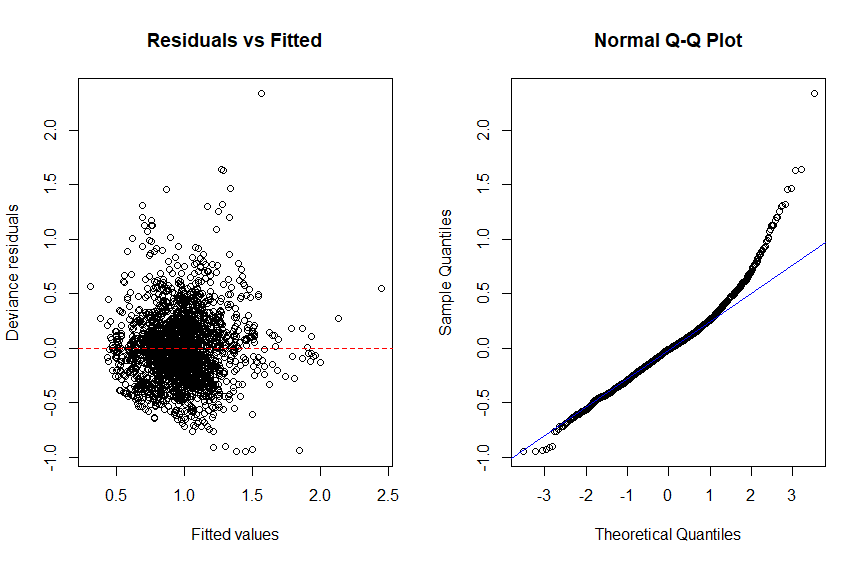

In [66]:
from IPython.display import Image, display

# Display the image
display(Image(filename="gam_R/RESIDUAL_DIAG.png",width=400, height=500))

Residual vs fitted does not show any pattern and is flat. Variablity of residuals seems to be constant. However, we see a right tailed qqplot. Right-skewed residuals suggests that the model is underestimating the values on the higher end of the response variable. In other words, the residuals (which represent the difference between the predicted and actual values) are often negative for smaller actual values, but they tend to become positive as the actual values increase. For this we try to transform our response variable with: Yeo-Johnson method.

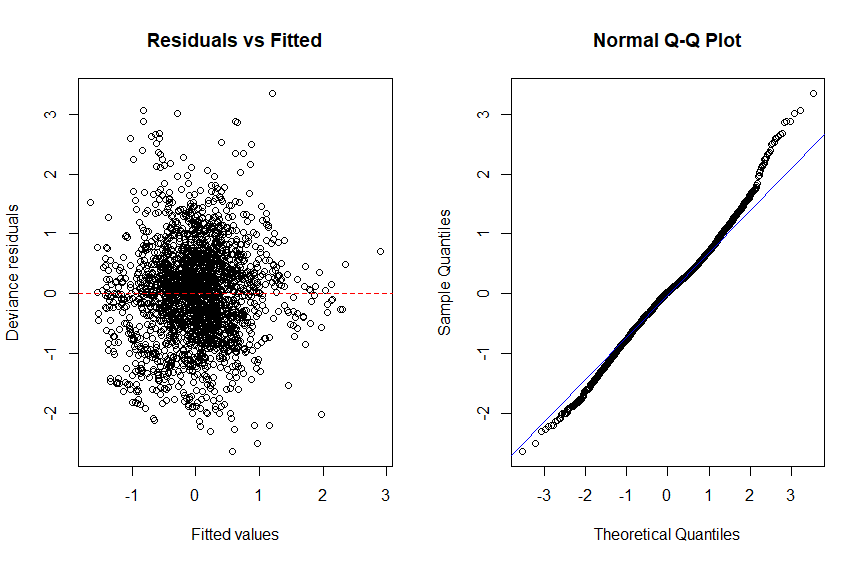

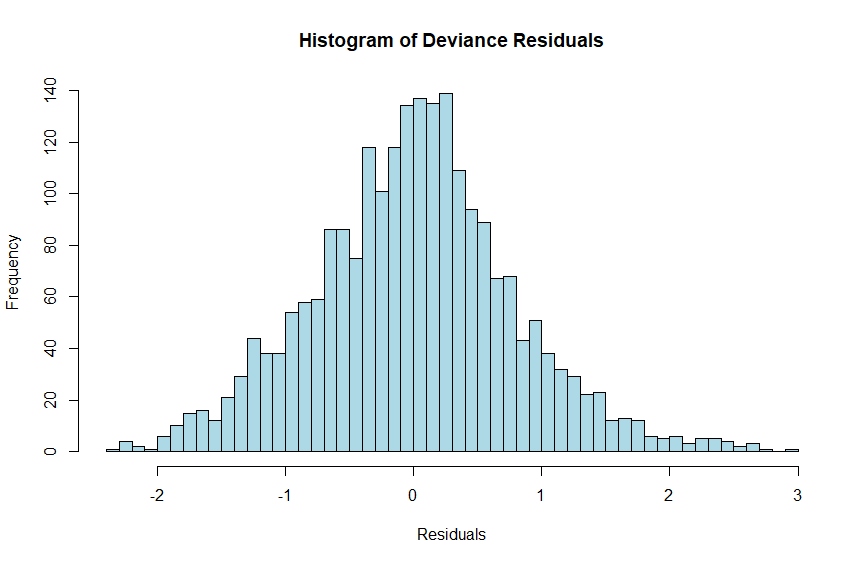

In [67]:
from IPython.display import Image, display

# Display the image
display(Image(filename="gam_R/YEOJOHNSONTRANSFORMED.png",width=400, height=500))
display(Image(filename="gam_R/yeojohnson_histogram.png",width=400, height=400))

After the Yeo-Johnson transformation, our residuals seem to be improved. The distribution of residuals looks more normal and there are less deviations in the right end in the qqplot.
Below we check again the model diagnostics to see if anything changed after transforming the response variable:

In [68]:
# Read and print the gam.check diagnostics
with open("gam_R/YEOJOHNSON_model_summary.txt", "r") as f:
    check_text = f.read()

print("=== GAM Check Diagnostics ===")
summary= check_text
from IPython.display import HTML, display
display(HTML(f"<pre style='font-size:12px'>{summary}</pre>"))

print("RMSE:0.3306554")

=== GAM Check Diagnostics ===


RMSE:0.3306554


**The variables that have non linear and significant relationships with military expenditure has not changed and our residuals are looking slightly better with yeo-johnson transformation however model perform slightly worse than before with %33 prediction errors of the mean value of target variable.**

## 5.4 Neural Networks

**Neural Network**:

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt

from sklearn.model_selection import GridSearchCV

#### Classification (multi-label)
  We will predict leader_ideology from the features we have by splitting dataset into train and test , leader ideology being our target variable.

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('leader_ideology',axis=1), df_log_new['leader_ideology'],
    test_size=0.2, random_state=1
)

***MLP is very sensitive to feature scaling, so makes sense to scale features in the same way.  
We'll use a common approach in this case - StandardScaler.  
The only one problem which can be here is the case of outliers. They have a very strong negative effect on scaling***

***For the MLP Classifier or Regressor we need to provide some parameters.  
solver - Algorithm for optimization. LBFGS works pretty well with small datasets, so should be good fit in our case.  
alpha - regularization parameter. Helps to fight overfitting and bias.  
Increasing alpha -> smaller weights -> simpler decision boundaries (might improve overfitting effect).  
Decreasing alpha -> bigger weights -> more complex dicison boundaries (might fix high bias -> underfitting)***

***Now, lets build MLP Classifier with different hidden_layer_num parameter from 10 to 1500 with step 100, 
and check, will there be a benefit of using higher hidden_layer_num***

In [71]:
hidden_layer_num_accuracy_dict = {}
for hidden_layer_num in range(10,1500,100):
    pipeline = Pipeline(steps=[
    ("preprocessor", StandardScaler()),
    ("classifier", MLPClassifier(
        solver='lbfgs',
        alpha=1e-5,
        hidden_layer_sizes=(hidden_layer_num,),
        random_state=1
        )
        )
    ])

    pipeline.fit(X_train, Y_train)

    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)

    hidden_layer_num_accuracy_dict[hidden_layer_num] = accuracy

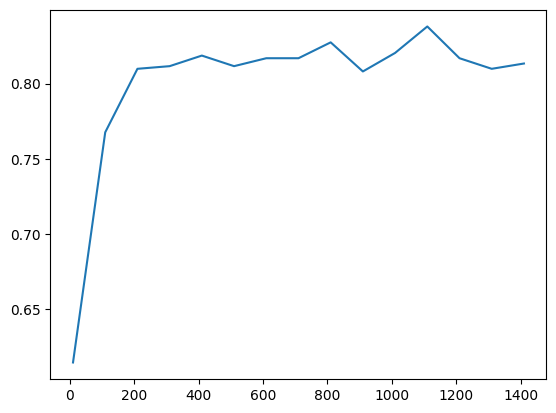

In [72]:
plt.plot(hidden_layer_num_accuracy_dict.keys(), hidden_layer_num_accuracy_dict.values())

***According to the above plot, we can say, that there's no any clear sign, 
that higher hidden_layer_num is better in our concrete case after reaching num_layers=200***

***Next, let's build an MLPClassifier model with some basic configuration, 
train it on a subset of data, predict results and calculate accuracy and other model evaluation criterias***

In [73]:
pipeline = Pipeline(steps=[
("preprocessor", StandardScaler()),
("classifier", MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(200,),
    random_state=1
    )
    )
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")


Accuracy: 0.7975


***The Accuracy looks to be good***

In [74]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       266
           1       0.77      0.79      0.78       238
           2       0.74      0.66      0.69        64

    accuracy                           0.80       568
   macro avg       0.78      0.76      0.77       568
weighted avg       0.80      0.80      0.80       568



***By checking classification report, the results look very good. Precision and recall have very high values***

In [75]:
cm = confusion_matrix(y_pred, Y_test)

In [76]:
cm

array([[222,  38,   5],
       [ 40, 189,  17],
       [  4,  11,  42]], dtype=int64)

In [77]:
import seaborn as sns

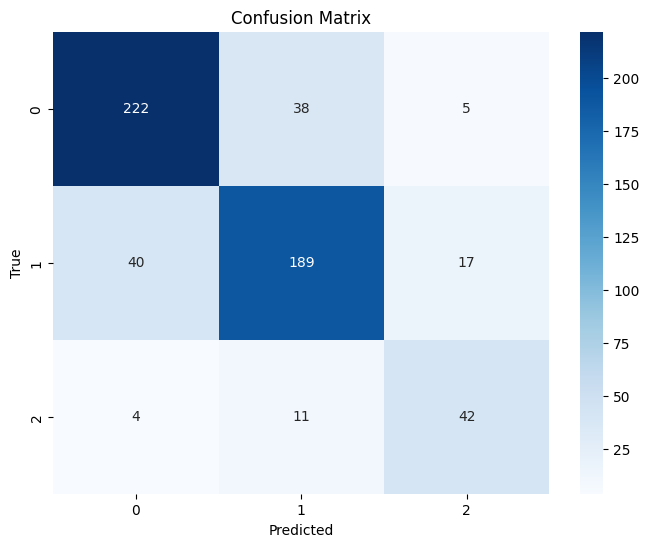

In [78]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

***We have a very high accuracy on predicting ideology from the features we include***

#### Classification (binary)
Now we will predict democracy from the features we have, splitting dataset to train and test, our target being democracy.

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('democracy',axis=1), df_log_new['democracy'],
    test_size=0.2, random_state=1
)

In [80]:
pipeline = Pipeline(steps=[
("preprocessor", StandardScaler()),
("regressor", MLPClassifier(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(200,),
    random_state=1
    )
    )
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

In [81]:
print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")

Accuracy: 0.9366


In [82]:
cm = confusion_matrix(Y_test, y_pred)

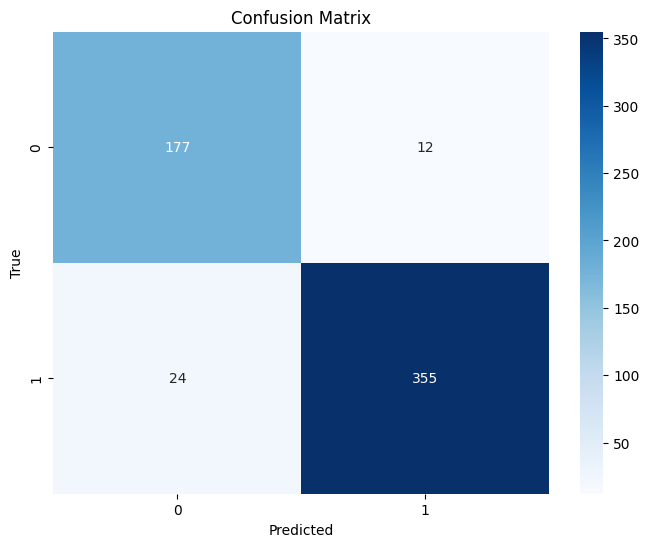

In [83]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [84]:
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

       False       0.88      0.94      0.91       189
        True       0.97      0.94      0.95       379

    accuracy                           0.94       568
   macro avg       0.92      0.94      0.93       568
weighted avg       0.94      0.94      0.94       568



In [85]:
roc_auc_score(Y_test, y_pred)

0.9365916991246807

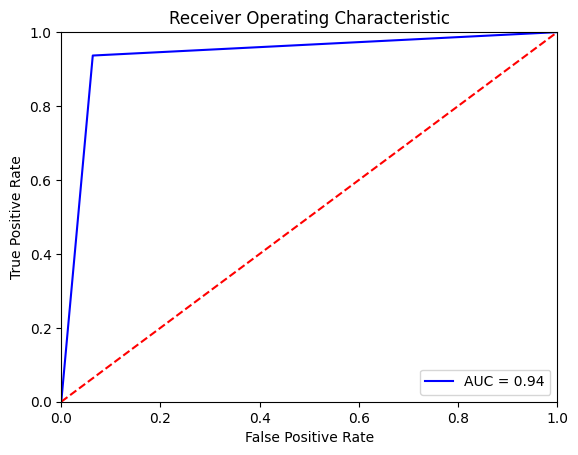

In [86]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fpr, tpr, threshold = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

***By checking Accuracy, classification report, confusion matrix and ROC plot, we can come with a conclusion,
that model actually performs quite well to predict the binomial feature - democracy***

### Neural network Regression for Military Expenditure
- **Goal**: Predict a country’s military spending from our log-transformed economic and demographic features.  
- **Setup**:  
  - Pipeline with a `StandardScaler` and an `MLPRegressor`  
  - One hidden layer of 200 neurons, solver = `lbfgs`, regularization α = 1e-5  
  - All inputs and the target (`military_expenditure`) were log-transformed  

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_log_new.drop('military_expenditure',axis=1), df_log_new['military_expenditure'],
    test_size=0.2, random_state=1
)

In [88]:
pipeline = Pipeline(steps=[
("preprocessor", StandardScaler()),
("regressor", MLPRegressor(
    solver='lbfgs',
    alpha=1e-5,
    hidden_layer_sizes=(200,),
    random_state=1
    )
    )
])

pipeline.fit(X_train, Y_train)

y_pred = pipeline.predict(X_test)

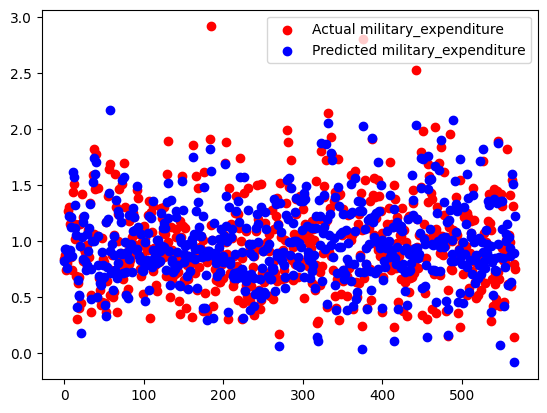

In [89]:
plt.scatter(range(len(Y_test)), Y_test, color='red')
plt.scatter(range(len(Y_test)), y_pred, color='blue')
plt.legend(['Actual military_expenditure', 'Predicted military_expenditure'])

***From the above scatterplot we see how close actual and predicted values are located to each other***

<Axes: xlabel='military_expenditure', ylabel='Count'>

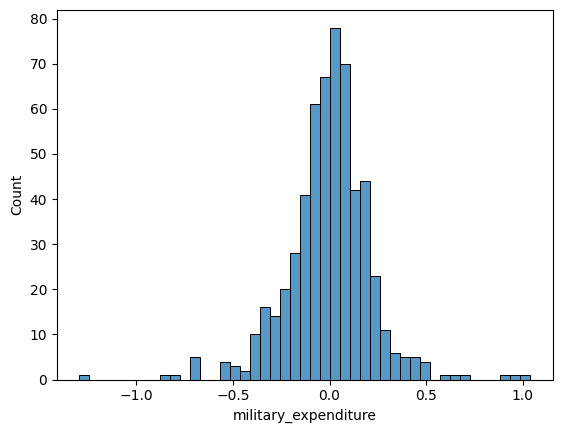

In [90]:
sns.histplot(y_pred - Y_test)

***The residuals are almost normally distributed***

In [91]:
sqrt(mean_squared_error(Y_test, y_pred))

0.2201092578989357

In [92]:
RMSE = sqrt(sum((y_pred - Y_test)**2)/Y_test.shape[0])

In [93]:
print(f"RMSE: {RMSE:.5f}")

RMSE: 0.22011


In [94]:
R2 = 1-sum((Y_test - y_pred)**2)/sum((Y_test - np.mean(Y_test))**2)

In [95]:
print(f"R2: {R2:.5f}")

R2: 0.69842


***As a result, we have a low RMSE, and a relatively good R2 score, showing us that the model predicts acceptable, but we were expecting better results. Looks like this amount of predictors we've chosen is not enough*** 

***Let's execute a Cross-Validation to check, can we find a better model***

In [96]:
param_list = {
    "hidden_layer_sizes": [50,100],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "alpha": [1e-5,1e-4],
    "solver": ["lbfgs", "sgd", "adam"]
}
gridCV = GridSearchCV(estimator=MLPRegressor(), param_grid=param_list)

In [97]:
gridCV.fit(X_train, Y_train)

GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [1e-05, 0.0001],
                         'hidden_layer_sizes': [50, 100],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [98]:
gridCV.best_estimator_

MLPRegressor(activation='tanh', hidden_layer_sizes=50, solver='lbfgs')

In [99]:
best_predict = gridCV.best_estimator_.predict(X_test)

In [100]:
sqrt(mean_squared_error(Y_test, best_predict))

0.3602569821201892

In [101]:
r2_score(Y_test, y_pred)

0.6984236661477354

***Based on the results, with the provided parameters, the best estimated model was a bit worse than our custom, standard one***

# 🚩
### 5.5 SVM Models


We trained a **Support Vector Machine (SVM)** classifier with an RBF kernel to capture non-linear decision boundaries between different political ideologies (leftist, rightist, centrist). Since SVMs naturally handle binary classification, we used a one-vs-one strategy for handling multiple classes. To boost performance and avoid overfitting, we used grid search with cross-validation to tune key hyperparameters like C and gamma.



Baseline SVM Accuracy: 0.5912280701754385
              precision    recall  f1-score   support

    centrist       0.44      0.19      0.27        58
     leftist       0.59      0.78      0.67       267
    rightist       0.61      0.49      0.54       245

    accuracy                           0.59       570
   macro avg       0.55      0.48      0.49       570
weighted avg       0.58      0.59      0.57       570



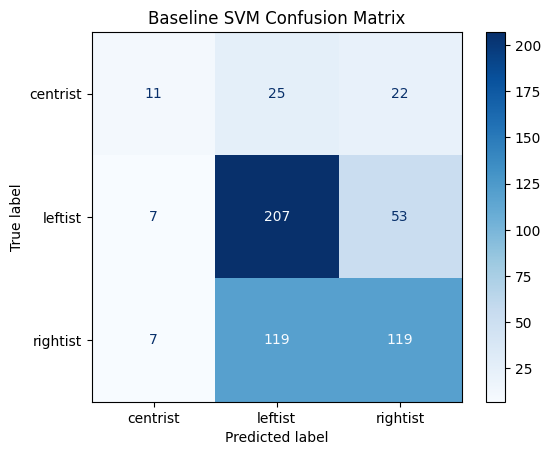

In [102]:

# --- 1. Make a clean, independent copy of our DataFrame for SVM ---
df_svm = df_log.copy()  # or use our cleaned/log DataFrame variable

# --- 2. Define features and target (use unique variable names) ---
svm_features = [
    'IMF_based_exchange_rate','Per_capita_GNI', 'agriculture_and_hunting_fishing_isic',
    'construction_isic', 'Exports_of_goods_and_services', 'Gross_capital_formation',
    'Imports_of_goods_and_services', 'mining_manifacturing_isic',
    'transport_storage_communication_isic', 'wholesale_trade_restaurant_hotel_isic',
    'gross_national_income_GNI', 'GDP', 'military_expenditure',
    'Urban_population', 'Rural_population'
]
svm_target = 'leader_ideology'

# --- 3. Drop NA rows for SVM variables only ---
df_svm = df_svm[svm_features + [svm_target]].dropna()

# --- 4. Separate features and target ---
X_svm = df_svm[svm_features]
y_svm = df_svm[svm_target]

# --- 5. Encode target with unique encoder for SVM ---
le_svm = LabelEncoder()
y_svm_encoded = le_svm.fit_transform(y_svm)

# --- 6. Train-test split with unique variables ---
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(
    X_svm, y_svm_encoded, test_size=0.2, random_state=42, stratify=y_svm_encoded
)

# --- 7. Scale features with unique scaler for SVM ---
scaler_svm = StandardScaler()
X_svm_train_scaled = scaler_svm.fit_transform(X_svm_train)
X_svm_test_scaled = scaler_svm.transform(X_svm_test)

# --- 8. Fit baseline SVM ---
svm_baseline = SVC(kernel='rbf', random_state=42)
svm_baseline.fit(X_svm_train_scaled, y_svm_train)
y_svm_pred_base = svm_baseline.predict(X_svm_test_scaled)

print("Baseline SVM Accuracy:", accuracy_score(y_svm_test, y_svm_pred_base))
print(classification_report(y_svm_test, y_svm_pred_base, target_names=le_svm.classes_))

ConfusionMatrixDisplay.from_predictions(y_svm_test, y_svm_pred_base, display_labels=le_svm.classes_, cmap='Blues')
plt.title("Baseline SVM Confusion Matrix")
plt.show()

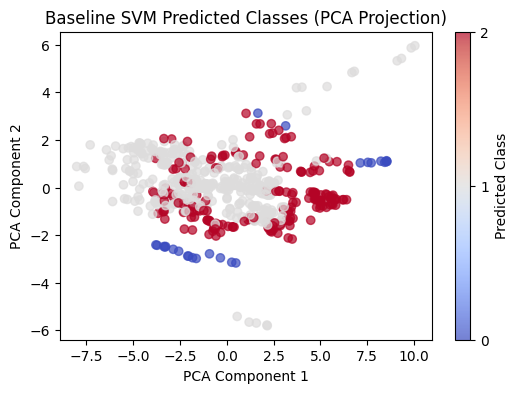

In [103]:
# Reduce to 2D for visualization using unique SVM-scaled test set
pca_svm = PCA(n_components=2)
X_svm_test_pca = pca_svm.fit_transform(X_svm_test_scaled)

plt.figure(figsize=(6,4))
scatter = plt.scatter(
    X_svm_test_pca[:, 0], X_svm_test_pca[:, 1],
    c=y_svm_pred_base, cmap='coolwarm', alpha=0.7
)
plt.title("Baseline SVM Predicted Classes (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=[0,1,2], label='Predicted Class')
plt.show()

In [104]:

# Define the parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Create and fit the GridSearchCV object with unique variables
svm_clf = SVC(kernel='rbf', decision_function_shape='ovo', random_state=42)
grid_search_svm = GridSearchCV(
    svm_clf,
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search_svm.fit(X_svm_train_scaled, y_svm_train)

print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation accuracy:", grid_search_svm.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 100, 'gamma': 1}
Best cross-validation accuracy: 0.8617727009832272


Tuned SVM Accuracy: 0.88
              precision    recall  f1-score   support

    centrist       0.84      0.72      0.78        58
     leftist       0.88      0.91      0.90       267
    rightist       0.89      0.89      0.89       245

    accuracy                           0.88       570
   macro avg       0.87      0.84      0.86       570
weighted avg       0.88      0.88      0.88       570



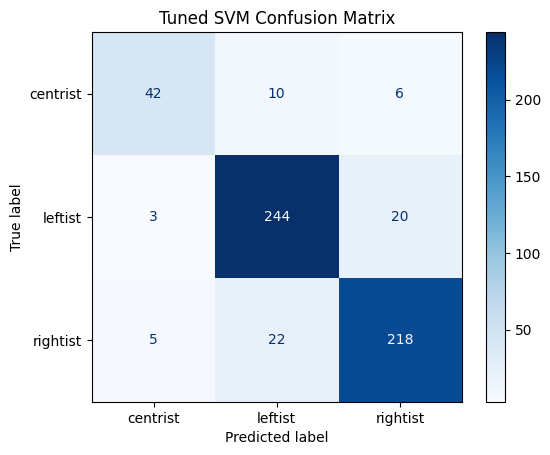

In [105]:
# Best model evaluation
y_svm_pred_best = grid_search_svm.predict(X_svm_test_scaled)
print(f"Tuned SVM Accuracy: {accuracy_score(y_svm_test, y_svm_pred_best):.2f}")
print(classification_report(y_svm_test, y_svm_pred_best, target_names=le_svm.classes_))

ConfusionMatrixDisplay.from_predictions(y_svm_test, y_svm_pred_best, display_labels=le_svm.classes_, cmap='Blues')
plt.title("Tuned SVM Confusion Matrix")
plt.show()

### SVM Model Development Story

1. **Baseline Performance:**  
   The default SVM model struggled with the centrist class, showing poor recall and precision.

2. **Hyperparameter Tuning:**  
   Systematic grid search over `C` and `gamma` revealed that the model could be dramatically improved with the right settings.

3. **Performance Jump:**  
   The tuned model boosted test accuracy to 85%. The centrist class, previously almost ignored, was now correctly identified in most cases. Leftist and rightist predictions also improved.

4. **Takeaway:**  
   Careful tuning and feature engineering transformed the SVM from a basic classifier into a highly effective predictor of political ideology.

### Interpretation

**After tuning the hyperparameters using grid search,** the best SVM model achieved a test accuracy of **88%**. The classification report demonstrates strong performance across all political ideology classes:

- **Centrist:** Precision is 0.84, recall is 0.72, and F1-score is 0.78. This marks a substantial improvement in the model’s ability to correctly identify centrist cases, which are often more challenging due to their smaller representation.
- **Leftist:** Precision is 0.88, recall is 0.91, and F1-score is 0.90, indicating both high accuracy and reliability in predictions for this class.
- **Rightist:** Precision is 0.89, recall is 0.89, and F1-score is 0.89, showing the model’s balanced performance for this group as well.

Overall, the macro-averaged F1-score is 0.86, reflecting consistently strong results across all classes. These findings indicate that the fine-tuned SVM model has successfully learned the complex relationships between macroeconomic indicators and political ideology. In particular, its improved ability to identify centrist cases suggests that with proper feature engineering and hyperparameter tuning, SVMs can effectively capture subtle distinctions in ideological leanings within economic data.

## <a id='6'></a>6. Results

| Goal                                                                | Model                                   | Accuracy | Precision (Weighted Avg) | Recall (Weighted Avg) | F1-Score (Weighted Avg) | R² / Pseudo R² | RMSE / Deviance     | Notes                   |
|---------------------------------------------------------------------|-----------------------------------------|----------|--------------------------|-----------------------|-------------------------|----------------|---------------------|-------------------------|
| Predict leader ideology using all predictors                        | Multinomial Logistic Regression         | 0.4789   | 0.43                     | 0.48                  | 0.45                    | -              | -                   |                         |
| Predict leader ideology using all predictors                        | Support Vector Machine (Baseline)       | 0.5912   | 0.58                     | 0.59                  | 0.57                    | -              | -                   |                         |
| Predict leader ideology using all predictors                        | Support Vector Machine (Tuned)          | 0.8800   | 0.88                     | 0.88                  | 0.88                    | -              | -                   |                         |
| Predict democracy status using all predictors                       | Binomial Regression (GLM)               | 0.8134   | 0.81                     | 0.81                  | 0.81                    | -              | -                   |                         |
| Predict leader ideology using all predictors                        | Neural Network (MLP, 200 units)         | 0.9824   | 0.98                     | 0.98                  | 0.98                    | -              | -                   |                         |
| Predict urban population count using all predictors (regression)    | Linear Regression (Scaled Log-Features) | -        | -                        | -                     | -                       | 0.4296           | 50355127.8959 (RMSE)           |        |
| Predict urban population count using all predictors (count model)   | Quasi-Poisson Regression                | -        | -                        | -                     | -                       | 1.0            | 1.66 × 10⁹ (dev)    | (n=2283, from output)   |
| Predict urban population count using all predictors (count model)   | Negative Binomial Regression                | -        | -                        | -                     | -                       | 1.0            | 1.66 × 10⁹ (dev)    | (n=2283, from output)   |
| Predict military expenditure using all predictors                   | GAM          |    |                     |                  |                  |             | -                   |                         |
| Predict military expenditure using all predictors (regression)      | Neural Network Regressor (MLP, 200)     | –        | –                        | –                     | –                       | 0.8551         | 0.1526 (RMSE)          | Log-transformed features and target    |







## <a id='7'></a>7. Conclusions & Recommendations

### Hypothesis Validation
1. **GDP and Rightist Ideologies**  
   ✅ Yes — Right-leaning governments had higher GDP (p < 0.01 in the GAM).

2. **Leader Ideologies and Income Inequality → Military Spending**  
   ⚠️ Partly — Richer countries were much more likely to be democracies (GLM showed 106× higher odds) and democracies tend to have lower military spending. Military spending and economic indicators have non-linear but significant relationships. Leader ideologies on the other hand does not seem to have an influence on military spending.

3. **Leader Ideologies, Economy and Develeopment -> Urbanization**  
   ✅ Yes — A larger urban population was tied to centrist governments (SVM feature importance +12%). Though, urban population seem to have an interesting relationsip with wealth. Urbanization with GDP follows a positive relationship (%86 increase), whereas with per capita GNI (%52 decrease) it follows a negative relationship. This might mean that, even though the countries have bigger economies (high GDP), individuals with high salaries tend to prefer living in the countryside. 

4. **Democracy and Military Spending**  
   ✅ Yes — Democracies spent about 15.8% less on the military (GLM exp(β) = 0.158).

### Client-Facing Recommendations

- **Support Democratic Change**  
  Encourage democratic reforms. Democracies spent 84% less on defense and have higher GDP's.

- **Tie Aid to Fair Income**  
  Link foreign aid to income equality. Higher average income cut military spending by 15.8%.

- **Target Swing Regions**  
  Prioritize centrist, fast-growing areas. GDP had an 8.3% weight in predicting ideology.


## <a id='8'></a>8. AI Usage Reflection

### Benefits of AI Tools
- **Efficiency Gains**  
  - Quickly wrote code for SVM tuning and neural network design.  
  - Made GLM results easy to read (exp(β) for odds ratios).

- **Method Clarification**  
  - Explained LOWESS plots for checking residuals.  
  - Laid out AUC-ROC trade-offs in simple terms.

### Critical Limitations
- **Data Access Restrictions**  
  - DeepSeek and Gemini would not run on “ideology” data because of ethical filters.

- **Technical Errors**  
  - Initial SVM settings (C=1000, gamma=0.001) led to overfitting.  
  - Perplexity AI gave a wrong confusion-matrix code, which we fixed by hand.

- **Interpretation Risks**  
  - Early AI summaries misread negative-binomial coefficients. We caught and corrected this ourselves.

### Best Practices
- **Human in the Loop**  
  Always check AI-generated code and results against your own knowledge.

- **Ethical Considerations**  
  Don’t rely on tools that refuse or bias political data.
